In [55]:
class GlobalVars():
    global_threshold = 400
    global_max = 1000000
    time_steps = 4000

In [56]:
# import lib.python.lib_FHRR as lib
# import lib.python.utility as util
# import lib.python.reuse_model as app

# -*- coding: utf-8 -*-
"""
Created on Sun Feb  5 19:33:37 2023

@author: vidura
"""
#%% LIB

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt
import math

from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort


# In[2]:

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt
import math


# In[ ]:


'''
Find gradient of a [x], [y] data paired 2 lists
'''
import random
def find_gradient(x, y):
    if (len(x) != len(y)):
        assert("Dimensions does not match")
    lst_size = len(x)
    gradients = {}
    for i in range(1, lst_size-1):
        m1 = 0
        m2 = 0
        rnd_int = i
        x1 = x[rnd_int]
        x2 = x[rnd_int + 1]
        x3 = x[rnd_int - 1]
        m1 = (y[rnd_int + 1] - y[rnd_int])     / (x2 - x1)
        m2 = (y[rnd_int    ] - y[rnd_int - 1]) / (x1 - x3)
        if (round(m1,2) == round(m2,2)):
            if (m1 > 0):
                gradients[round(m1,2)] = i
    gradients = ({k: v for k, v in sorted(gradients.items(), key=lambda item: item[1])})
    return list(gradients.keys())



# In[ ]:


'''Function to convert polar Z to rect Z
'''
def pol2complex(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return complex(x, y)

'''Function to convert polar [Z] to rect [Z]'''
def phase2complex_array(arr):
    new_arr = [pol2complex(1,x) for x in arr]
    return new_arr

'''Function to convert rect [Z] to polar [Z]
   and clean the angle'''
import cmath
def complexarr2phase(arr):
    phase_arr = [cmath.phase(x) for x in arr]
    for i in range(len(phase_arr)):
        while(phase_arr[i] < 0):
            phase_arr[i] += 2 * cmath.pi
    return phase_arr

'''Function to clean polar [Z] angle'''
def cleanphase(arr):
    for i in range(len(arr)):
        while arr[i] < 0:
            arr[i] += 2 * cmath.pi
        
        while arr[i] > 2*cmath.pi:
            arr[i] -= 2 * cmath.pi
    
    return arr

'''Function to convert Rad [Z] to Degree [Z]'''
def convert_rad2deg(arr, round_val = False):
    if round_val == False:
        return [180 * x / cmath.pi  for x in arr]
    else:
        return [round(180 * x / cmath.pi, 1)  for x in arr]

'''Function to convert Degree [Z] to Rad [Z]'''
def convert_deg2rad(arr, round_val = False):
    if round_val == False:
        return [cmath.pi * x / 180 for x in arr]
    else:
        return [round(cmath.pi * x / 180, 1) for x in arr]

'''Function to place all elements of [vec] on unit circle'''
def normalize_cmplx(vec):
    rslt = [ z/abs(z) for z in vec]
    return rslt


# In[4]:


def show_voltages(title_lst, vec, figsize):
    if len(title_lst) != len(vec):
        assert("Dimensions does not match")
    
    dim = len(vec)
    figure, axis = plt.subplots(dim, figsize=figsize)
    
    
    for i in range(dim):
        title = title_lst[i]
        x = [x for x in range(0, len(vec[i]))]
        axis[i].plot(x, vec[i])
        axis[i].title.set_text(title)
        
    plt.show()                       
    
# def show_gradients(title_lst, vec):
#     vec = np.array(vec)
#     for i in range(len(vec)):
#         grad = find_gradient( [x for x in range(len(vec[i]))], vec[i])
#         print(f'{title[i]} : {grad}')
        


# In[ ]:


'''
Cosine similarity of [v2] relative to [v1]
'''
def similarity(v1, v2):
    if (len(v1) != len(v2)):
        assert("Dimensions do not match!")
    v1_phase = complexarr2phase(v1)
    v2_phase = complexarr2phase(v2)
    error_v = np.array([ math.cos(a-b) 
                        for a, b in zip(v1_phase, v2_phase) ])
    return np.sum(error_v) / len(v1)


'''
Convert complex array to degree angle array
'''
def getAngleArr(arr, rounded = True):
    return convert_rad2deg(complexarr2phase(arr), rounded)


# In[4]:


class FHRR_Encoder(AbstractProcess):
    def __init__(self, vec : [complex]):
        super().__init__()
        hd_vec = complexarr2phase(vec)
        shape = (len(hd_vec),)
        self.spikes_out = OutPort(shape=shape)  # Input spikes to the classifier
        self.input_vec = Var(shape=shape, init=hd_vec)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
    def get_v(self):
        return self.v.get()

class FHRR_Decoder(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        dim = dimension
        shape = (dim,)
        self.spikes_a_in = InPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.decoded_a = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        
    def get_v(self):
        return self.v.get()
    
    def get_decoded_value(self):
        return self.decoded_a.get()
    
class FHRR_Sum(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        self.dim = Var(shape=(1,), init=dimension)
        shape = (dimension,)
        self.spikes_a_in = InPort(shape=shape)
        self.spikes_b_in = InPort(shape=shape)
        self.spikes_out = OutPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.b_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        self.b_period = Var(shape=shape, init=GlobalVars.global_max)
        self.phase_arr_clean = Var(shape=shape, init=0)
        
    def get_v(self):
        return self.v.get()
    
    def get_phase_arr_clean(self):
        return self.phase_arr_clean.get()
    
class FHRR_Multiply(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        self.dim = Var(shape=(1,), init=dimension)
        shape = (dimension,)
        self.spikes_a_in = InPort(shape=shape)
        self.spikes_b_in = InPort(shape=shape)
        self.spikes_out = OutPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.b_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        self.b_period = Var(shape=shape, init=GlobalVars.global_max)
        
    def get_v(self):
        return self.v.get()


# In[5]:


import numpy as np
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.model.py.model import PyLoihiProcessModel

@implements(proc=FHRR_Encoder, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    input_vec: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    v: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.v = np.zeros(self.v.shape)

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        self.v[:] = self.v + self.input_vec
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)

@implements(proc=FHRR_Sum, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeSumModel(PyLoihiProcessModel):   
    dim: int = LavaPyType(int, int, precision=32)
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    spikes_b_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    phase_arr_clean: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    b_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    b_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
#         print("Run Post Management")
        self.v          = np.zeros((self.v.shape))
        self.a_last_spk = np.zeros((self.v.shape))
        self.b_last_spk = np.zeros((self.v.shape))

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
#         print(f"time : {self.time_step}")
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        
        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_a = GlobalVars.global_threshold / self.a_period
        complex_arr_a = phase2complex_array(decoded_a)
        
        ###############################################################################
        
        new_spike_times = self.spikes_b_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.b_last_spk * new_spikes
        self.b_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.b_period
        
        masked_last_spike_inv = self.b_last_spk * new_spikes_inv
        self.b_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_b = GlobalVars.global_threshold / self.b_period
        complex_arr_b = phase2complex_array(decoded_b)
        
        ##############################################################################################

#         print(f"decoded_a         : {[item * 180 / cmath.pi for item in decoded_a]}")
#         print(f"decoded_b         : {[item * 180 / cmath.pi for item in decoded_b]}")
        
        sum_complex = [a + b for a,b in zip(complex_arr_a, complex_arr_b)]
        
        phase_arr = complexarr2phase(sum_complex)
        self.phase_arr_clean = cleanphase(phase_arr)
        
#         print(f"phase_arr_clean    : {[item * 180 / cmath.pi for item in self.phase_arr_clean]}")
        
        self.v[:] = self.v + self.phase_arr_clean
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)
        

@implements(proc=FHRR_Multiply, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeMultModel(PyLoihiProcessModel):   
    dim: int = LavaPyType(int, int, precision=32)
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    spikes_b_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    b_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    b_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.v          = np.zeros((self.v.shape))
        self.a_last_spk = np.zeros((self.v.shape))
        self.b_last_spk = np.zeros((self.v.shape))


    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
#         print(f"time : {self.time_step}")
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        

        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_a = GlobalVars.global_threshold / self.a_period
        
        ###############################################################################
        
        new_spike_times = self.spikes_b_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.b_last_spk * new_spikes
        self.b_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.b_period
        
        masked_last_spike_inv = self.b_last_spk * new_spikes_inv
        self.b_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_b = GlobalVars.global_threshold / self.b_period
        
        ##############################################################################################
        
#         print(f"decoded_a         : {[item * 180 / cmath.pi for item in decoded_a]}")
#         print(f"decoded_b         : {[item * 180 / cmath.pi for item in decoded_b]}")
        
        mult_phase = [a + b for a,b in zip(decoded_a, decoded_b)]
        
        mult_phase_cleaned = cleanphase(mult_phase)
        
#         print(f"mult_phase_cleaned         : {[item * 180 / cmath.pi for item in mult_phase_cleaned]}")
        
        self.v[:] = self.v + mult_phase_cleaned
        s_out = self.v > self.vth
        self.v[s_out] = 0
        self.spikes_out.send(s_out)
        


# In[6]:


@implements(proc=FHRR_Decoder, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeDecoderModel(PyLoihiProcessModel):        
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    decoded_a: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == GlobalVars.time_steps - 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
#         print(f"decoded_val  : {[item * 180 / cmath.pi for item in self.decoded_a]}")

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        
        ###############################################################################
        
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        

        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        self.decoded_a = GlobalVars.global_threshold / self.a_period
        
#         print(f"decoded_val         : {[item * 180 / cmath.pi for item in self.decoded_a]}")
#         print(f'a_period            : {self.a_period}')
        
        self.v[:] = self.v + self.decoded_a
        s_out = self.v > self.vth
        self.v[s_out] = 0
        


#%%

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

class FHRR_SNN_Model():
    
    def __init__(self, dimension, run_loihi=False):
        
        # if (run_loihi):
        #     import lib_FHRR_Loihi as lib
        #     print("Loihi Library Loaded!")
        # else:
        #     import lib_FHRR as lib
        
        self.dimension = dimension
        self.hd1 = np.zeros(dimension)
        self.hd2 = np.zeros(dimension)
        self.n1  = FHRR_Encoder(vec = self.hd1)
        self.n2  = FHRR_Encoder(vec = self.hd2)
        self.add = FHRR_Sum(dimension=dimension)
        self.mul = FHRR_Multiply(dimension=dimension)
        self.decode_mul   = FHRR_Decoder(dimension=dimension)
        self.decode_add   = FHRR_Decoder(dimension=dimension)
        
        self.n1.spikes_out.connect(self.mul.spikes_a_in)
        self.n2.spikes_out.connect(self.mul.spikes_b_in)
        self.mul.spikes_out.connect(self.decode_mul.spikes_a_in)
        
        self.n1.spikes_out.connect(self.add.spikes_a_in)
        self.n2.spikes_out.connect(self.add.spikes_b_in)
        self.add.spikes_out.connect(self.decode_add.spikes_a_in)
        
        self.run_loihi = run_loihi
        self.run_cfg = Loihi1SimCfg()
        
        # if (self.run_loihi):
        #     self.run_cfg = Loihi2HwCfg()
        
        # Just init the runtime 
        self.decode_mul.run(condition=
                            RunSteps(
                                num_steps=1), 
                            run_cfg=self.run_cfg)
        
        self.voltage_n1 = []
        self.voltage_n2 = []
        self.voltage_mult = []
        self.voltage_add  = []
        self.voltage_deco_mult = []
        self.voltage_deco_add = []
    
    '''
    Cosine similarity of [v2] relative to [v1]
    '''
    def similarity(self, v1, v2):
        if (len(v1) != len(v2)):
            assert("Dimensions do not match!")
        v1_phase = complexarr2phase(v1)
        v2_phase = complexarr2phase(v2)
        error_v = np.array([ math.cos(a-b) 
                            for a, b in zip(v1_phase, v2_phase) ])
        return np.sum(error_v) / len(v1)
    
    '''
    Binding using normal binding logic
    '''
    def bind_py(self, v1, v2):
        rslt = [ (a * b) for a, b in zip(v1, v2) ]
        return rslt
    
    def bundle_py(self, v1, v2):
        v1_norm  = normalize_cmplx(v1)
        v2_norm  = normalize_cmplx(v2)
        
        rslt = [ (a + b) for a, b in zip(v1_norm, v2_norm) ]
        return rslt
    
    def run(self, condition, run_cfg, debug=False):

        if (debug == False):
            self.decode_mul.run(condition=condition,run_cfg=run_cfg)
        else:
            for i in range(GlobalVars.time_steps):
                self.voltage_n1.append(self.n1.get_v())
                self.voltage_n2.append(self.n2.get_v())
                self.voltage_mult.append(self.mul.get_v())
                self.voltage_add.append(self.add.get_v())
                self.voltage_deco_mult.append(self.decode_mul.get_v())
                self.voltage_deco_add.append(self.decode_add.get_v())
                self.decode_mul.run(condition=
                            RunSteps(num_steps=1), 
                            run_cfg=self.run_cfg)
                
        return self.voltage_n1, self.voltage_n2, self.voltage_mult, self.voltage_add, self.voltage_deco_mult, self.voltage_deco_add
        
    '''
    Binding using Lava SNN
    '''
    def bind(self, v1, v2, debug = False):
        self.n1.input_vec.set(np.array(complexarr2phase(v1)))
        self.n2.input_vec.set(np.array(complexarr2phase(v2)))
        
        self.n1.v.set(np.zeros(self.dimension))
        self.n2.v.set(np.zeros(self.dimension))
        self.mul.a_last_spk.set(np.zeros(self.dimension))
        self.mul.b_last_spk.set(np.zeros(self.dimension))
        self.mul.a_period.set(np.full((self.mul.a_period.shape), GlobalVars.global_max))
        self.mul.b_period.set(np.full((self.mul.b_period.shape), GlobalVars.global_max))
        self.mul.v.set(np.zeros(self.dimension))
        
        self.decode_mul.v.set(np.zeros(self.dimension))
        self.decode_mul.decoded_a.set(np.zeros(self.dimension)) 
        self.decode_mul.a_last_spk.set(np.zeros(self.dimension))
        self.decode_mul.a_period.set(np.full((self.mul.a_period.shape), GlobalVars.global_max))
        
        voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add = self.run(condition=
                             RunSteps(num_steps=GlobalVars.time_steps),
                             run_cfg=self.run_cfg, debug=debug)
                 
                 
        raw_rslt  = self.decode_mul.get_decoded_value()
        
#         print(f'raw_rslt : {raw_rslt}')
        
        rect_rslt = phase2complex_array(raw_rslt)
        
        return rect_rslt, [voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add]
    
    '''
    Bundle using Lava SNN
    '''
    def bundle(self, v1, v2, debug = False):
        self.n1.input_vec.set(np.array(complexarr2phase(v1)))
        self.n2.input_vec.set(np.array(complexarr2phase(v2)))
        
        self.n1.v.set(np.zeros(self.dimension))
        self.n2.v.set(np.zeros(self.dimension))
        self.add.a_last_spk.set(np.zeros(self.dimension))
        self.add.b_last_spk.set(np.zeros(self.dimension))
        self.add.a_period.set(np.full((self.add.a_period.shape), GlobalVars.global_max))
        self.add.b_period.set(np.full((self.add.b_period.shape), GlobalVars.global_max))
        self.add.v.set(np.zeros(self.dimension))
        
        self.decode_add.v.set(np.zeros(self.dimension))
        self.decode_add.decoded_a.set(np.zeros(self.dimension)) 
        self.decode_add.a_last_spk.set(np.zeros(self.dimension))
        self.decode_add.a_period.set(np.full((self.mul.a_period.shape), GlobalVars.global_max))
        
        voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add = self.run(condition=
                             RunSteps(num_steps=GlobalVars.time_steps),
                             run_cfg=self.run_cfg, debug=debug)
                 
                 
        raw_rslt  = self.decode_add.get_decoded_value()
        rect_rslt = phase2complex_array(raw_rslt)
        
        return rect_rslt, [voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add]

In [83]:
#%%

d = 1000

snn = FHRR_SNN_Model(d)
#%%

In [84]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math, cmath
from tqdm import tqdm
from tqdm import notebook as nb

class hdv:
    dim=0
    def __init__(self, dim=0):
        self.dim = dim
        
    def get_rv(self):
        pass
    
    def bind(self, v1, v2):
        pass
    
    def bundle(self, arr_v):
        pass
    
    def similarity(self, v1, v2):
        pass
    
    def set_dim(self, dim):
        self.dim = dim
        
class FHRR(hdv):
    upper = math.pi
    lower = -math.pi
    def get_rv(self):
        angles = np.random.uniform(self.lower, self.upper, self.dim)
        elems = [ cmath.exp(1j*theta) for theta in angles ]
        return np.array(elems)
    
    def bind_old(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 + a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    def unbind(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 - a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    def bundle_old(self, arr_v):
        rslt = np.zeros(self.dim)
        for v in arr_v:
            rslt = np.add(rslt, v)
        
        rslt_int = [ cmath.exp((cmath.polar(c)[1])*1j) for c in rslt]
        
        return np.array(rslt_int)
    
    def similarity(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        
        sum_angles = 0
        for i in range(self.dim):
            sum_angles += (cmath.cos(angles_v1[i].real - angles_v2[i].real)).real
            
        return sum_angles / self.dim
   
    '''
    New function to bundle using SNN
    '''
    def bundle(self, arr_v):
        snn_rslt = np.copy(arr_v[0])
        with nb.tqdm(total=len(arr_v)-1) as pbar:
            for i in range(1,len(arr_v)):
                snn_rslt, voltages = snn.bundle(snn_rslt, arr_v[i])
                pbar.update(1)
        return snn_rslt
    
    def bind(self, v1, v2):
        snn_rslt, voltages = snn.bind(v1, v2)
        return snn_rslt
#%%

In [85]:
fhrr = FHRR(d)

## Bundling

### Expected curve if sufficient time steps are run

Vth : 400


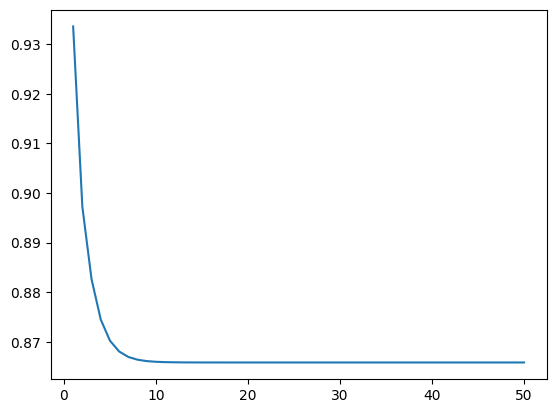

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import cmath

#%%

def func(x, e):
    if (x <= 1):
        return e
    return 4 * e * (1 - 2**(-x))

def func_cos(x, e):
    prob_danger = 1/(2*cmath.pi) * (2*e)
    return cmath.cos(func(x,e)) * (1-prob_danger) + (-1)*prob_danger

#%%
Vth = GlobalVars.global_threshold
print(f'Vth : {Vth}')

e = (4 * cmath.pi ** 2) / (2 * cmath.pi + Vth)

x = [i+1 for i in range(50)]
y = [func_cos(i, e)  for i in x]

plt.plot(x, y)

### Simulation results

In [32]:
N = 50
rvs = [fhrr.get_rv() for i in range(N)]

In [33]:
# import pickle

# outfile3 = open("rvs_sudden_drop", 'wb')
# pickle.dump(rvs, outfile3)
# outfile3.close()

# print("All saved!")

In [34]:
vec_snn = fhrr.bundle([rvs[0], rvs[1]])
vec_py  = fhrr.bundle_old([rvs[0], rvs[1]])
similarity = []
similarity.append( fhrr.similarity(vec_snn, vec_py) )
# with nb.tqdm(total=(N-2)) as pbar:
for i in range(2,N):
    print(f'sum  : {getAngleArr(vec_snn, False)}')
    print(f'rv_i : {getAngleArr(rvs[i], False)}')
    vec_snn = fhrr.bundle([vec_snn, rvs[i]])
    vec_py  = fhrr.bundle_old([vec_py, rvs[i]])
    sim =  fhrr.similarity(vec_snn, vec_py)
    print(i, sim)
    similarity.append(sim)

  0%|          | 0/1 [00:00<?, ?it/s]

sum  : [229.18311805232926, 104.17414456924058, 24.69645668667341, 318.3098861837907, 127.32395447351627, 154.85345814346573, 229.18311805232926, 112.34466571192613, 318.3098861837907, 337.0339971357784, 48.97075172058318, 11.345698913481646, 53.05164769729844, 179.04931097838227, 154.85345814346573, 16.231099012204623, 150.77836713969035, 184.82509520349132, 260.4353614231015, 119.36620731892151, 318.3098861837907, 184.82509520349132, 110.18419137131217, 154.85345814346573, 318.3098861837907, 249.11208483948835, 301.5567342793807, 44.41533295587778, 114.59155902616465, 86.81178714103383, 67.40679942715568, 260.4353614231015, 85.516088825496, 12.482740634658459, 15.402091266957612, 110.18419137131217, 318.3098861837907, 301.5567342793807, 238.73241463784296, 112.34466571192613, 249.11208483948835, 69.87290184522234, 59.683103659460755, 150.77836713969035, 40.34914050217065, 318.3098861837907, 56.17233285596306, 3.4308850007833724, 136.418522650196, 318.3098861837907, 337.0339971357784,

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.9050515563512269
sum  : [229.18311805232926, 65.10884035577537, 301.5567342793807, 30.155673427938062, 204.627783975294, 119.36620731892151, 212.20659078919377, 43.405893570516916, 286.4788975654116, 318.3098861837907, 130.21768071155074, 301.5567342793807, 26.282467666551526, 163.7022271802352, 197.5716534933873, 318.3098861837907, 95.4929658551372, 124.55604241974417, 173.62357428206766, 29.232540567899147, 318.3098861837907, 97.11149070013953, 42.44131815783875, 136.418522650196, 337.0339971357784, 272.837045300392, 318.3098861837907, 95.4929658551372, 110.18419137131217, 159.15494309189535, 65.10884035577537, 204.627783975294, 30.639454285070762, 24.59046331033576, 41.219985261210304, 93.9275073984956, 260.4353614231015, 30.31522725559911, 260.4353614231015, 168.5169985678892, 318.3098861837907, 337.0339971357784, 56.72849456740824, 179.04931097838227, 318.3098861837907, 301.5567342793807, 318.3098861837907, 337.0339971357784, 168.5169985678892, 34.104630662549, 3.4473994893551

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.8547654442446082
sum  : [229.18311805232926, 21.06462482098615, 249.11208483948835, 3.594465465061627, 110.18419137131217, 159.15494309189535, 272.837045300392, 318.3098861837907, 220.3683827426243, 337.0339971357784, 112.34466571192613, 19.291508253563073, 108.10524436430626, 197.5716534933873, 112.34466571192613, 229.18311805232926, 106.10329539459688, 112.34466571192613, 100.51891142646022, 81.8511135901176, 358.09862195676453, 146.91225516174956, 1.629109454452156, 190.9859317102744, 12.455604241974418, 286.4788975654116, 249.11208483948835, 53.54745748886198, 42.44131815783875, 65.8572178311291, 79.57747154594767, 204.627783975294, 95.4929658551372, 301.5567342793807, 89.52465548919113, 168.5169985678892, 212.20659078919377, 65.10884035577537, 238.73241463784296, 168.5169985678892, 7.519131169695841, 272.837045300392, 88.14735309704974, 179.04931097838227, 318.3098861837907, 220.3683827426243, 337.0339971357784, 318.3098861837907, 112.34466571192613, 19.098593171027435, 358.09

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.8281660546581555
sum  : [249.11208483948835, 14.359844489494316, 238.73241463784296, 337.0339971357784, 150.77836713969035, 220.3683827426243, 272.837045300392, 16.80228138213558, 260.4353614231015, 301.5567342793807, 43.405893570516916, 40.63530461920732, 159.15494309189535, 114.59155902616465, 97.11149070013953, 229.18311805232926, 150.77836713969035, 106.10329539459688, 159.15494309189535, 154.85345814346573, 52.08707228462029, 108.10524436430626, 52.08707228462029, 159.15494309189535, 272.837045300392, 318.3098861837907, 272.837045300392, 15.038262339391686, 318.3098861837907, 127.32395447351627, 133.24599886763332, 159.15494309189535, 78.48736919600317, 249.11208483948835, 146.91225516174956, 190.9859317102744, 249.11208483948835, 337.0339971357784, 260.4353614231015, 179.04931097838227, 11.887091185286792, 229.18311805232926, 31.830988618379067, 133.24599886763332, 337.0339971357784, 249.11208483948835, 249.11208483948835, 318.3098861837907, 119.36620731892151, 318.3098861837

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.8087307976356806
sum  : [318.3098861837907, 74.41010326374328, 154.85345814346573, 337.0339971357784, 124.55604241974417, 143.2394487827058, 260.4353614231015, 301.5567342793807, 318.3098861837907, 337.0339971357784, 119.36620731892151, 108.10524436430626, 190.9859317102744, 163.7022271802352, 104.17414456924058, 272.837045300392, 121.90591385762197, 22.827003790072638, 143.2394487827058, 229.18311805232926, 51.156945993823506, 154.85345814346573, 62.96239506932124, 159.15494309189535, 179.04931097838227, 272.837045300392, 337.0339971357784, 72.52630318111687, 20.033489340238575, 190.9859317102744, 124.55604241974417, 190.9859317102744, 100.51891142646022, 204.627783975294, 127.32395447351627, 127.32395447351627, 301.5567342793807, 318.3098861837907, 272.837045300392, 173.62357428206766, 337.0339971357784, 184.82509520349132, 102.31389198764701, 44.07367654852487, 337.0339971357784, 260.4353614231015, 286.4788975654116, 6.961820110945604, 104.17414456924058, 26.043536142310142, 318

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.8079796093870981
sum  : [17.849152496287328, 116.93016227159659, 229.18311805232926, 260.4353614231015, 77.42672907173286, 143.2394487827058, 286.4788975654116, 318.3098861837907, 286.4788975654116, 272.837045300392, 159.15494309189535, 154.85345814346573, 220.3683827426243, 88.14735309704974, 73.45612758087478, 260.4353614231015, 173.62357428206766, 337.0339971357784, 74.41010326374328, 286.4788975654116, 32.554420177887685, 229.18311805232926, 139.7458036904447, 102.31389198764701, 150.77836713969035, 337.0339971357784, 33.11894769542331, 6.585721783112911, 286.4788975654116, 260.4353614231015, 79.57747154594767, 139.7458036904447, 173.62357428206766, 249.11208483948835, 89.52465548919113, 190.9859317102744, 318.3098861837907, 272.837045300392, 260.4353614231015, 139.7458036904447, 35.15078497735112, 204.627783975294, 30.155673427938062, 116.93016227159659, 32.18864017588895, 318.3098861837907, 318.3098861837907, 84.2584992839446, 39.51433069867746, 301.5567342793807, 337.0339971

  0%|          | 0/1 [00:00<?, ?it/s]

7 0.8097769269328905
sum  : [22.736420441699334, 57.29577951308232, 204.627783975294, 286.4788975654116, 133.24599886763332, 85.516088825496, 337.0339971357784, 8.994627867045889, 238.73241463784296, 212.20659078919377, 163.7022271802352, 133.24599886763332, 159.15494309189535, 98.78582674669364, 15.871407067335825, 197.5716534933873, 212.20659078919377, 318.3098861837907, 25.693174669543644, 272.837045300392, 89.52465548919113, 212.20659078919377, 154.85345814346573, 136.418522650196, 106.10329539459688, 337.0339971357784, 35.80986219567645, 272.837045300392, 318.3098861837907, 173.62357428206766, 143.2394487827058, 108.10524436430626, 204.627783975294, 212.20659078919377, 81.8511135901176, 220.3683827426243, 318.3098861837907, 249.11208483948835, 249.11208483948835, 68.209261325098, 337.0339971357784, 272.837045300392, 301.5567342793807, 173.62357428206766, 108.10524436430626, 272.837045300392, 30.155673427938062, 41.51868080658139, 62.96239506932124, 10.551708934269305, 337.03399713

  0%|          | 0/1 [00:00<?, ?it/s]

8 0.7978535685003438
sum  : [301.5567342793807, 112.34466571192613, 168.5169985678892, 2.624634883787555, 73.45612758087478, 21.220659078919375, 25.35211482879749, 318.3098861837907, 184.82509520349132, 286.4788975654116, 204.627783975294, 150.77836713969035, 150.77836713969035, 168.5169985678892, 40.63530461920732, 130.21768071155074, 249.11208483948835, 260.4353614231015, 286.4788975654116, 197.5716534933873, 124.55604241974417, 154.85345814346573, 197.5716534933873, 143.2394487827058, 40.34914050217065, 47.35188389510936, 110.18419137131217, 272.837045300392, 337.0339971357784, 136.418522650196, 57.87452476068922, 33.11894769542331, 173.62357428206766, 136.418522650196, 159.15494309189535, 286.4788975654116, 337.0339971357784, 220.3683827426243, 318.3098861837907, 52.56493533310305, 23.8732414637843, 260.4353614231015, 337.0339971357784, 249.11208483948835, 143.2394487827058, 249.11208483948835, 44.41533295587778, 57.87452476068922, 2.1653733753999367, 32.74044543604704, 6.444969574

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.7846638228998996
sum  : [9.486056210775219, 146.91225516174956, 83.03736161316279, 35.367765131532295, 130.21768071155074, 301.5567342793807, 75.38918356984517, 238.73241463784296, 197.5716534933873, 229.18311805232926, 204.627783975294, 119.36620731892151, 130.21768071155074, 133.24599886763332, 40.63530461920732, 139.7458036904447, 260.4353614231015, 272.837045300392, 212.20659078919377, 133.24599886763332, 104.17414456924058, 95.4929658551372, 220.3683827426243, 179.04931097838227, 358.09862195676453, 301.5567342793807, 78.48736919600317, 220.3683827426243, 318.3098861837907, 71.6197243913529, 80.6982810043413, 337.0339971357784, 146.91225516174956, 55.09209568565608, 212.20659078919377, 249.11208483948835, 301.5567342793807, 260.4353614231015, 318.3098861837907, 70.73553026306459, 301.5567342793807, 286.4788975654116, 337.0339971357784, 220.3683827426243, 110.18419137131217, 229.18311805232926, 318.3098861837907, 358.09862195676453, 286.4788975654116, 301.5567342793807, 86.8117

  0%|          | 0/1 [00:00<?, ?it/s]

10 0.7777131290899796
sum  : [35.367765131532295, 212.20659078919377, 12.29523165516788, 32.00881537043705, 116.93016227159659, 272.837045300392, 74.41010326374328, 229.18311805232926, 229.18311805232926, 260.4353614231015, 163.7022271802352, 100.51891142646022, 52.08707228462029, 154.85345814346573, 106.10329539459688, 173.62357428206766, 249.11208483948835, 301.5567342793807, 159.15494309189535, 146.91225516174956, 30.155673427938062, 10.976202971854851, 146.91225516174956, 229.18311805232926, 56.17233285596306, 260.4353614231015, 27.679120537720927, 139.7458036904447, 6.6934321861077475, 337.0339971357784, 10.551708934269305, 272.837045300392, 168.5169985678892, 104.17414456924058, 139.7458036904447, 197.5716534933873, 220.3683827426243, 179.04931097838227, 249.11208483948835, 337.0339971357784, 301.5567342793807, 190.9859317102744, 238.73241463784296, 179.04931097838227, 33.11894769542331, 154.85345814346573, 260.4353614231015, 286.4788975654116, 337.0339971357784, 17.7386314281988

  0%|          | 0/1 [00:00<?, ?it/s]

11 0.7878411128990794
sum  : [318.3098861837907, 139.7458036904447, 53.05164769729844, 337.0339971357784, 95.4929658551372, 249.11208483948835, 337.0339971357784, 301.5567342793807, 260.4353614231015, 318.3098861837907, 88.14735309704974, 81.8511135901176, 61.60836506783045, 159.15494309189535, 146.91225516174956, 133.24599886763332, 238.73241463784296, 260.4353614231015, 168.5169985678892, 179.04931097838227, 30.155673427938062, 286.4788975654116, 197.5716534933873, 146.91225516174956, 81.8511135901176, 272.837045300392, 71.6197243913529, 47.35188389510936, 92.41254760174569, 4.504385181846095, 64.3772803517779, 173.62357428206766, 121.90591385762197, 124.55604241974417, 84.2584992839446, 143.2394487827058, 238.73241463784296, 159.15494309189535, 220.3683827426243, 301.5567342793807, 249.11208483948835, 204.627783975294, 220.3683827426243, 197.5716534933873, 80.6982810043413, 220.3683827426243, 337.0339971357784, 220.3683827426243, 36.26315159055844, 318.3098861837907, 143.23944878270

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.8082071676586591
sum  : [6.6934321861077475, 47.35188389510936, 26.282467666551526, 229.18311805232926, 130.21768071155074, 260.4353614231015, 16.32358390686106, 14.843466195099046, 286.4788975654116, 337.0339971357784, 159.15494309189535, 163.7022271802352, 56.17233285596306, 146.91225516174956, 168.5169985678892, 190.9859317102744, 249.11208483948835, 272.837045300392, 173.62357428206766, 119.36620731892151, 70.73553026306459, 301.5567342793807, 190.9859317102744, 61.60836506783045, 4.163937464613541, 318.3098861837907, 110.18419137131217, 110.18419137131217, 86.81178714103383, 59.067813931012694, 116.93016227159659, 139.7458036904447, 154.85345814346573, 139.7458036904447, 337.0339971357784, 220.3683827426243, 190.9859317102744, 220.3683827426243, 197.5716534933873, 260.4353614231015, 204.627783975294, 220.3683827426243, 212.20659078919377, 173.62357428206766, 71.6197243913529, 168.5169985678892, 260.4353614231015, 260.4353614231015, 6.533156158846332, 249.11208483948835, 114.5

  0%|          | 0/1 [00:00<?, ?it/s]

13 0.7911134278995077
sum  : [92.41254760174569, 84.2584992839446, 337.0339971357784, 173.62357428206766, 190.9859317102744, 229.18311805232926, 337.0339971357784, 86.81178714103383, 179.04931097838227, 37.44822190397538, 102.31389198764701, 179.04931097838227, 50.25945571323011, 212.20659078919377, 179.04931097838227, 220.3683827426243, 318.3098861837907, 337.0339971357784, 249.11208483948835, 190.9859317102744, 14.505260636223372, 212.20659078919377, 133.24599886763332, 19.291508253563073, 90.94568176679734, 301.5567342793807, 78.48736919600317, 106.10329539459688, 42.44131815783875, 318.3098861837907, 58.46508113579829, 127.32395447351627, 229.18311805232926, 190.9859317102744, 12.062269371175224, 146.91225516174956, 220.3683827426243, 146.91225516174956, 163.7022271802352, 249.11208483948835, 249.11208483948835, 146.91225516174956, 249.11208483948835, 90.94568176679734, 150.77836713969035, 112.34466571192613, 190.9859317102744, 179.04931097838227, 318.3098861837907, 260.43536142310

  0%|          | 0/1 [00:00<?, ?it/s]

14 0.776157393556611
sum  : [58.46508113579829, 71.6197243913529, 301.5567342793807, 220.3683827426243, 150.77836713969035, 168.5169985678892, 272.837045300392, 95.4929658551372, 204.627783975294, 41.219985261210304, 52.56493533310305, 114.59155902616465, 102.31389198764701, 124.55604241974417, 220.3683827426243, 249.11208483948835, 260.4353614231015, 249.11208483948835, 272.837045300392, 204.627783975294, 62.27802120987209, 124.55604241974417, 53.54745748886198, 23.774182370573573, 93.9275073984956, 260.4353614231015, 104.17414456924058, 168.5169985678892, 104.17414456924058, 272.837045300392, 337.0339971357784, 85.516088825496, 212.20659078919377, 249.11208483948835, 85.516088825496, 116.93016227159659, 163.7022271802352, 163.7022271802352, 154.85345814346573, 238.73241463784296, 286.4788975654116, 179.04931097838227, 220.3683827426243, 139.7458036904447, 108.10524436430626, 93.9275073984956, 179.04931097838227, 190.9859317102744, 337.0339971357784, 286.4788975654116, 197.57165349338

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.7757626147637701
sum  : [98.78582674669364, 150.77836713969035, 318.3098861837907, 121.90591385762197, 173.62357428206766, 238.73241463784296, 168.5169985678892, 136.418522650196, 136.418522650196, 116.93016227159659, 119.36620731892151, 190.9859317102744, 154.85345814346573, 124.55604241974417, 179.04931097838227, 301.5567342793807, 179.04931097838227, 204.627783975294, 260.4353614231015, 190.9859317102744, 52.56493533310305, 212.20659078919377, 78.48736919600317, 31.309169132831876, 163.7022271802352, 190.9859317102744, 78.48736919600317, 229.18311805232926, 52.56493533310305, 301.5567342793807, 286.4788975654116, 42.1292496419723, 249.11208483948835, 272.837045300392, 85.516088825496, 37.44822190397538, 197.5716534933873, 212.20659078919377, 163.7022271802352, 184.82509520349132, 272.837045300392, 114.59155902616465, 286.4788975654116, 190.9859317102744, 24.803367754581096, 17.738631428198865, 168.5169985678892, 212.20659078919377, 8.994627867045889, 301.5567342793807, 229.1831

  0%|          | 0/1 [00:00<?, ?it/s]

16 0.7814150858386363
sum  : [159.15494309189535, 163.7022271802352, 238.73241463784296, 65.8572178311291, 197.5716534933873, 301.5567342793807, 204.627783975294, 102.31389198764701, 114.59155902616465, 150.77836713969035, 114.59155902616465, 139.7458036904447, 100.51891142646022, 50.70422965759498, 229.18311805232926, 14.843466195099046, 184.82509520349132, 112.34466571192613, 318.3098861837907, 204.627783975294, 38.71336453586643, 139.7458036904447, 89.52465548919113, 35.367765131532295, 190.9859317102744, 212.20659078919377, 119.36620731892151, 173.62357428206766, 5.194540300370111, 238.73241463784296, 318.3098861837907, 59.067813931012694, 179.04931097838227, 260.4353614231015, 80.6982810043413, 112.34466571192613, 197.5716534933873, 212.20659078919377, 92.41254760174569, 159.15494309189535, 184.82509520349132, 44.41533295587778, 286.4788975654116, 220.3683827426243, 18.90949818913608, 301.5567342793807, 212.20659078919377, 229.18311805232926, 38.197186342054884, 220.3683827426243,

  0%|          | 0/1 [00:00<?, ?it/s]

17 0.7808148752652522
sum  : [146.91225516174956, 249.11208483948835, 179.04931097838227, 114.59155902616465, 260.4353614231015, 260.4353614231015, 212.20659078919377, 59.683103659460755, 133.24599886763332, 114.59155902616465, 179.04931097838227, 163.7022271802352, 127.32395447351627, 133.24599886763332, 204.627783975294, 286.4788975654116, 229.18311805232926, 130.21768071155074, 238.73241463784296, 119.36620731892151, 318.3098861837907, 130.21768071155074, 106.10329539459688, 6.088818226682498, 220.3683827426243, 212.20659078919377, 67.40679942715568, 121.90591385762197, 286.4788975654116, 197.5716534933873, 238.73241463784296, 337.0339971357784, 150.77836713969035, 197.5716534933873, 10.551708934269305, 190.9859317102744, 127.32395447351627, 229.18311805232926, 100.51891142646022, 139.7458036904447, 168.5169985678892, 86.81178714103383, 229.18311805232926, 238.73241463784296, 15.569505302468022, 286.4788975654116, 260.4353614231015, 204.627783975294, 358.09862195676453, 127.32395447

  0%|          | 0/1 [00:00<?, ?it/s]

18 0.7779115524743452
sum  : [80.6982810043413, 318.3098861837907, 88.14735309704974, 26.899427001447098, 179.04931097838227, 238.73241463784296, 184.82509520349132, 337.0339971357784, 112.34466571192613, 173.62357428206766, 90.94568176679734, 212.20659078919377, 119.36620731892151, 53.54745748886198, 139.7458036904447, 238.73241463784296, 272.837045300392, 150.77836713969035, 272.837045300392, 150.77836713969035, 41.219985261210304, 52.08707228462029, 121.90591385762197, 6.452227422644407, 143.2394487827058, 163.7022271802352, 337.0339971357784, 48.14771387653977, 229.18311805232926, 260.4353614231015, 212.20659078919377, 358.09862195676453, 197.5716534933873, 133.24599886763332, 13.940578956954337, 102.31389198764701, 197.5716534933873, 184.82509520349132, 159.15494309189535, 102.31389198764701, 179.04931097838227, 358.09862195676453, 238.73241463784296, 154.85345814346573, 84.2584992839446, 249.11208483948835, 204.627783975294, 238.73241463784296, 61.60836506783045, 139.745803690444

  0%|          | 0/1 [00:00<?, ?it/s]

19 0.7960190643458612
sum  : [119.36620731892151, 301.5567342793807, 22.55739350908753, 34.515529827158026, 143.2394487827058, 286.4788975654116, 229.18311805232926, 229.18311805232926, 119.36620731892151, 119.36620731892151, 168.5169985678892, 150.77836713969035, 179.04931097838227, 53.05164769729844, 168.5169985678892, 150.77836713969035, 337.0339971357784, 163.7022271802352, 197.5716534933873, 143.2394487827058, 318.3098861837907, 62.96239506932124, 104.17414456924058, 272.837045300392, 78.48736919600317, 212.20659078919377, 272.837045300392, 337.0339971357784, 184.82509520349132, 238.73241463784296, 163.7022271802352, 28.7918490015489, 272.837045300392, 204.627783975294, 301.5567342793807, 39.51433069867746, 150.77836713969035, 150.77836713969035, 163.7022271802352, 14.39592450077445, 249.11208483948835, 59.683103659460755, 229.18311805232926, 168.5169985678892, 69.03105965431605, 173.62357428206766, 179.04931097838227, 220.3683827426243, 70.73553026306459, 97.11149070013953, 173.6

  0%|          | 0/1 [00:00<?, ?it/s]

20 0.8060844527523389
sum  : [77.42672907173286, 229.18311805232926, 14.217315015653181, 61.60836506783045, 98.78582674669364, 318.3098861837907, 159.15494309189535, 229.18311805232926, 179.04931097838227, 197.5716534933873, 98.78582674669364, 159.15494309189535, 212.20659078919377, 41.82173687086301, 150.77836713969035, 173.62357428206766, 45.47284088339867, 116.93016227159659, 249.11208483948835, 184.82509520349132, 272.837045300392, 73.45612758087478, 73.45612758087478, 272.837045300392, 18.364031895218695, 184.82509520349132, 286.4788975654116, 3.4453264890608737, 143.2394487827058, 229.18311805232926, 184.82509520349132, 337.0339971357784, 238.73241463784296, 272.837045300392, 301.5567342793807, 358.09862195676453, 173.62357428206766, 159.15494309189535, 229.18311805232926, 337.0339971357784, 301.5567342793807, 114.59155902616465, 179.04931097838227, 204.627783975294, 150.77836713969035, 190.9859317102744, 127.32395447351627, 249.11208483948835, 83.03736161316279, 150.778367139690

  0%|          | 0/1 [00:00<?, ?it/s]

21 0.8113826408283664
sum  : [73.45612758087478, 286.4788975654116, 33.31149971690833, 337.0339971357784, 184.82509520349132, 301.5567342793807, 212.20659078919377, 204.627783975294, 249.11208483948835, 220.3683827426243, 36.96501904069827, 119.36620731892151, 163.7022271802352, 119.36620731892151, 98.78582674669364, 127.32395447351627, 33.50630380882007, 116.93016227159659, 184.82509520349132, 95.4929658551372, 220.3683827426243, 64.3772803517779, 337.0339971357784, 229.18311805232926, 318.3098861837907, 249.11208483948835, 286.4788975654116, 15.871407067335825, 179.04931097838227, 204.627783975294, 143.2394487827058, 238.73241463784296, 197.5716534933873, 179.04931097838227, 318.3098861837907, 318.3098861837907, 212.20659078919377, 116.93016227159659, 154.85345814346573, 249.11208483948835, 249.11208483948835, 44.41533295587778, 102.31389198764701, 249.11208483948835, 229.18311805232926, 204.627783975294, 173.62357428206766, 154.85345814346573, 12.29523165516788, 100.51891142646022, 

  0%|          | 0/1 [00:00<?, ?it/s]

22 0.802017626460173
sum  : [110.18419137131217, 318.3098861837907, 318.3098861837907, 7.519131169695841, 249.11208483948835, 337.0339971357784, 229.18311805232926, 197.5716534933873, 168.5169985678892, 249.11208483948835, 45.11478701817506, 133.24599886763332, 150.77836713969035, 179.04931097838227, 102.31389198764701, 75.38918356984517, 90.94568176679734, 139.7458036904447, 92.41254760174569, 173.62357428206766, 272.837045300392, 150.77836713969035, 337.0339971357784, 190.9859317102744, 3.8505228167394026, 301.5567342793807, 260.4353614231015, 67.40679942715568, 110.18419137131217, 121.90591385762197, 127.32395447351627, 204.627783975294, 260.4353614231015, 108.10524436430626, 229.18311805232926, 28.505362941832, 159.15494309189535, 88.14735309704974, 204.627783975294, 204.627783975294, 238.73241463784296, 46.20627380087284, 39.51433069867746, 212.20659078919377, 229.18311805232926, 190.9859317102744, 204.627783975294, 168.5169985678892, 45.11478701817506, 184.82509520349132, 212.206

  0%|          | 0/1 [00:00<?, ?it/s]

23 0.7919010882779888
sum  : [146.91225516174956, 25.35211482879749, 337.0339971357784, 62.96239506932124, 229.18311805232926, 337.0339971357784, 163.7022271802352, 127.32395447351627, 124.55604241974417, 249.11208483948835, 9.76078015555065, 150.77836713969035, 121.90591385762197, 184.82509520349132, 102.31389198764701, 7.979913581209238, 146.91225516174956, 197.5716534933873, 93.9275073984956, 190.9859317102744, 249.11208483948835, 121.90591385762197, 10.976202971854851, 150.77836713969035, 24.59046331033576, 220.3683827426243, 204.627783975294, 46.20627380087284, 24.803367754581096, 143.2394487827058, 173.62357428206766, 272.837045300392, 318.3098861837907, 173.62357428206766, 173.62357428206766, 318.3098861837907, 168.5169985678892, 74.41010326374328, 249.11208483948835, 150.77836713969035, 301.5567342793807, 83.03736161316279, 337.0339971357784, 249.11208483948835, 286.4788975654116, 110.18419137131217, 173.62357428206766, 146.91225516174956, 100.51891142646022, 179.04931097838227

  0%|          | 0/1 [00:00<?, ?it/s]

24 0.789092267865548
sum  : [81.8511135901176, 93.9275073984956, 249.11208483948835, 119.36620731892151, 260.4353614231015, 286.4788975654116, 93.9275073984956, 179.04931097838227, 179.04931097838227, 301.5567342793807, 49.39291337334682, 92.41254760174569, 30.31522725559911, 168.5169985678892, 124.55604241974417, 301.5567342793807, 116.93016227159659, 249.11208483948835, 130.21768071155074, 168.5169985678892, 260.4353614231015, 89.52465548919113, 81.8511135901176, 173.62357428206766, 75.38918356984517, 249.11208483948835, 249.11208483948835, 337.0339971357784, 48.55574535006976, 220.3683827426243, 90.94568176679734, 184.82509520349132, 358.09862195676453, 104.17414456924058, 143.2394487827058, 301.5567342793807, 114.59155902616465, 98.78582674669364, 163.7022271802352, 146.91225516174956, 318.3098861837907, 133.24599886763332, 301.5567342793807, 238.73241463784296, 190.9859317102744, 42.44131815783875, 229.18311805232926, 85.516088825496, 71.6197243913529, 104.17414456924058, 212.2065

  0%|          | 0/1 [00:00<?, ?it/s]

25 0.7858631249535857
sum  : [154.85345814346573, 35.367765131532295, 301.5567342793807, 190.9859317102744, 301.5567342793807, 229.18311805232926, 97.11149070013953, 139.7458036904447, 150.77836713969035, 212.20659078919377, 3.640138469700275, 114.59155902616465, 337.0339971357784, 168.5169985678892, 89.52465548919113, 318.3098861837907, 62.27802120987209, 286.4788975654116, 139.7458036904447, 249.11208483948835, 286.4788975654116, 32.554420177887685, 56.17233285596306, 168.5169985678892, 64.3772803517779, 318.3098861837907, 272.837045300392, 47.35188389510936, 76.39437268410977, 127.32395447351627, 93.9275073984956, 119.36620731892151, 42.44131815783875, 179.04931097838227, 97.11149070013953, 9.486056210775219, 26.899427001447098, 130.21768071155074, 136.418522650196, 168.5169985678892, 229.18311805232926, 184.82509520349132, 337.0339971357784, 190.9859317102744, 98.78582674669364, 38.976720757198855, 163.7022271802352, 154.85345814346573, 337.0339971357784, 179.04931097838227, 179.04

  0%|          | 0/1 [00:00<?, ?it/s]

26 0.7847942343879873
sum  : [190.9859317102744, 337.0339971357784, 286.4788975654116, 124.55604241974417, 260.4353614231015, 159.15494309189535, 76.39437268410977, 56.17233285596306, 116.93016227159659, 272.837045300392, 272.837045300392, 106.10329539459688, 4.2821957782572735, 184.82509520349132, 136.418522650196, 301.5567342793807, 318.3098861837907, 337.0339971357784, 154.85345814346573, 260.4353614231015, 301.5567342793807, 26.282467666551526, 43.405893570516916, 136.418522650196, 139.7458036904447, 286.4788975654116, 190.9859317102744, 79.57747154594767, 26.162456398667725, 212.20659078919377, 59.067813931012694, 168.5169985678892, 119.36620731892151, 163.7022271802352, 84.2584992839446, 70.73553026306459, 79.57747154594767, 42.758044412748, 204.627783975294, 197.5716534933873, 173.62357428206766, 114.59155902616465, 16.80228138213558, 168.5169985678892, 36.96501904069827, 8.002203842609262, 136.418522650196, 65.8572178311291, 272.837045300392, 229.18311805232926, 139.74580369044

  0%|          | 0/1 [00:00<?, ?it/s]

27 0.7609318732944148
sum  : [146.91225516174956, 249.11208483948835, 238.73241463784296, 173.62357428206766, 337.0339971357784, 110.18419137131217, 88.14735309704974, 34.93645092261117, 163.7022271802352, 301.5567342793807, 286.4788975654116, 119.36620731892151, 61.60836506783045, 121.90591385762197, 173.62357428206766, 220.3683827426243, 337.0339971357784, 272.837045300392, 229.18311805232926, 318.3098861837907, 4.089634511997311, 337.0339971357784, 116.93016227159659, 212.20659078919377, 146.91225516174956, 301.5567342793807, 212.20659078919377, 49.822416967897674, 318.3098861837907, 173.62357428206766, 47.7464829275686, 190.9859317102744, 69.87290184522234, 102.31389198764701, 20.609992630605152, 77.42672907173286, 27.679120537720927, 318.3098861837907, 184.82509520349132, 249.11208483948835, 204.627783975294, 100.51891142646022, 79.57747154594767, 127.32395447351627, 337.0339971357784, 53.05164769729844, 163.7022271802352, 104.17414456924058, 238.73241463784296, 286.4788975654116,

  0%|          | 0/1 [00:00<?, ?it/s]

28 0.7800258574204533
sum  : [184.82509520349132, 238.73241463784296, 260.4353614231015, 238.73241463784296, 238.73241463784296, 146.91225516174956, 95.4929658551372, 337.0339971357784, 249.11208483948835, 318.3098861837907, 337.0339971357784, 46.9637536992478, 130.21768071155074, 30.31522725559911, 204.627783975294, 173.62357428206766, 272.837045300392, 286.4788975654116, 260.4353614231015, 13.232281642744185, 47.35188389510936, 249.11208483948835, 63.66197723675813, 168.5169985678892, 220.3683827426243, 229.18311805232926, 154.85345814346573, 58.46508113579829, 229.18311805232926, 139.7458036904447, 337.0339971357784, 212.20659078919377, 337.0339971357784, 98.78582674669364, 318.3098861837907, 43.737236269528495, 50.70422965759498, 318.3098861837907, 146.91225516174956, 173.62357428206766, 173.62357428206766, 28.505362941832, 136.418522650196, 212.20659078919377, 42.758044412748, 337.0339971357784, 190.9859317102744, 76.39437268410977, 150.77836713969035, 184.82509520349132, 112.3446

  0%|          | 0/1 [00:00<?, ?it/s]

29 0.7709027403439916
sum  : [97.11149070013953, 190.9859317102744, 301.5567342793807, 220.3683827426243, 190.9859317102744, 143.2394487827058, 10.976202971854851, 13.6418522650196, 212.20659078919377, 27.679120537720927, 3.2279312401736524, 301.5567342793807, 179.04931097838227, 75.38918356984517, 121.90591385762197, 154.85345814346573, 173.62357428206766, 272.837045300392, 238.73241463784296, 337.0339971357784, 337.0339971357784, 150.77836713969035, 133.24599886763332, 88.14735309704974, 184.82509520349132, 272.837045300392, 179.04931097838227, 50.70422965759498, 286.4788975654116, 139.7458036904447, 5.034778516088077, 272.837045300392, 238.73241463784296, 19.291508253563073, 238.73241463784296, 10.379670201645348, 67.40679942715568, 318.3098861837907, 154.85345814346573, 229.18311805232926, 159.15494309189535, 16.094320087944475, 45.47284088339867, 173.62357428206766, 98.78582674669364, 20.033489340238575, 212.20659078919377, 337.0339971357784, 85.516088825496, 238.73241463784296, 1

  0%|          | 0/1 [00:00<?, ?it/s]

30 0.7434069790426365
sum  : [86.81178714103383, 238.73241463784296, 12.29523165516788, 204.627783975294, 220.3683827426243, 179.04931097838227, 286.4788975654116, 23.386032454319317, 272.837045300392, 3.6965019040698275, 337.0339971357784, 249.11208483948835, 229.18311805232926, 98.78582674669364, 73.45612758087478, 65.8572178311291, 163.7022271802352, 220.3683827426243, 301.5567342793807, 9.30126290796791, 28.505362941832, 154.85345814346573, 163.7022271802352, 119.36620731892151, 238.73241463784296, 301.5567342793807, 133.24599886763332, 35.15078497735112, 337.0339971357784, 56.17233285596306, 20.389957122093357, 238.73241463784296, 168.5169985678892, 301.5567342793807, 163.7022271802352, 39.51433069867746, 116.93016227159659, 238.73241463784296, 136.418522650196, 286.4788975654116, 229.18311805232926, 301.5567342793807, 301.5567342793807, 150.77836713969035, 130.21768071155074, 337.0339971357784, 154.85345814346573, 272.837045300392, 168.5169985678892, 249.11208483948835, 127.32395

  0%|          | 0/1 [00:00<?, ?it/s]

31 0.7832149564530332
sum  : [173.62357428206766, 272.837045300392, 5.180450227222632, 150.77836713969035, 272.837045300392, 249.11208483948835, 272.837045300392, 80.6982810043413, 272.837045300392, 78.48736919600317, 37.44822190397538, 260.4353614231015, 143.2394487827058, 61.60836506783045, 159.15494309189535, 3.706065945218778, 220.3683827426243, 168.5169985678892, 14.843466195099046, 14.542076018548812, 78.48736919600317, 204.627783975294, 108.10524436430626, 102.31389198764701, 260.4353614231015, 260.4353614231015, 127.32395447351627, 16.511752021061184, 45.47284088339867, 112.34466571192613, 98.78582674669364, 260.4353614231015, 85.516088825496, 286.4788975654116, 184.82509520349132, 124.55604241974417, 69.87290184522234, 154.85345814346573, 77.42672907173286, 249.11208483948835, 173.62357428206766, 8.463187520396206, 318.3098861837907, 98.78582674669364, 168.5169985678892, 301.5567342793807, 190.9859317102744, 260.4353614231015, 146.91225516174956, 190.9859317102744, 77.42672907

  0%|          | 0/1 [00:00<?, ?it/s]

32 0.7941128134316905
sum  : [130.21768071155074, 272.837045300392, 318.3098861837907, 163.7022271802352, 229.18311805232926, 318.3098861837907, 229.18311805232926, 75.38918356984517, 238.73241463784296, 104.17414456924058, 7.117488138271097, 337.0339971357784, 212.20659078919377, 104.17414456924058, 197.5716534933873, 301.5567342793807, 229.18311805232926, 190.9859317102744, 78.48736919600317, 57.29577951308232, 139.7458036904447, 143.2394487827058, 71.6197243913529, 74.41010326374328, 197.5716534933873, 318.3098861837907, 102.31389198764701, 16.04923795884659, 46.58193456348157, 75.38918356984517, 150.77836713969035, 301.5567342793807, 60.311346855876124, 286.4788975654116, 104.17414456924058, 204.627783975294, 68.209261325098, 179.04931097838227, 83.03736161316279, 229.18311805232926, 197.5716534933873, 301.5567342793807, 44.07367654852487, 110.18419137131217, 190.9859317102744, 20.987465023107077, 238.73241463784296, 318.3098861837907, 229.18311805232926, 179.04931097838227, 92.412

  0%|          | 0/1 [00:00<?, ?it/s]

33 0.7713482424370893
sum  : [121.90591385762197, 286.4788975654116, 337.0339971357784, 146.91225516174956, 272.837045300392, 286.4788975654116, 212.20659078919377, 16.32358390686106, 220.3683827426243, 184.82509520349132, 272.837045300392, 301.5567342793807, 249.11208483948835, 110.18419137131217, 179.04931097838227, 2.0543484945529698, 168.5169985678892, 110.18419137131217, 98.78582674669364, 39.78873577297383, 114.59155902616465, 116.93016227159659, 358.09862195676453, 104.17414456924058, 229.18311805232926, 272.837045300392, 112.34466571192613, 102.31389198764701, 4.263078832818625, 337.0339971357784, 130.21768071155074, 27.949160738088935, 116.93016227159659, 220.3683827426243, 30.155673427938062, 133.24599886763332, 337.0339971357784, 154.85345814346573, 143.2394487827058, 238.73241463784296, 260.4353614231015, 8.463187520396206, 318.3098861837907, 33.11894769542331, 220.3683827426243, 318.3098861837907, 190.9859317102744, 318.3098861837907, 150.77836713969035, 124.55604241974417

  0%|          | 0/1 [00:00<?, ?it/s]

34 0.7751843744080501
sum  : [173.62357428206766, 249.11208483948835, 318.3098861837907, 173.62357428206766, 173.62357428206766, 220.3683827426243, 190.9859317102744, 100.51891142646022, 220.3683827426243, 212.20659078919377, 272.837045300392, 301.5567342793807, 229.18311805232926, 110.18419137131217, 112.34466571192613, 47.7464829275686, 114.59155902616465, 24.803367754581096, 85.516088825496, 337.0339971357784, 110.18419137131217, 159.15494309189535, 318.3098861837907, 150.77836713969035, 168.5169985678892, 260.4353614231015, 124.55604241974417, 49.822416967897674, 272.837045300392, 238.73241463784296, 52.08707228462029, 55.09209568565608, 139.7458036904447, 204.627783975294, 67.40679942715568, 136.418522650196, 220.3683827426243, 89.52465548919113, 97.11149070013953, 173.62357428206766, 260.4353614231015, 29.533906965506347, 25.35211482879749, 89.52465548919113, 121.90591385762197, 260.4353614231015, 249.11208483948835, 249.11208483948835, 93.9275073984956, 184.82509520349132, 93.92

  0%|          | 0/1 [00:00<?, ?it/s]

35 0.7681241879742692
sum  : [154.85345814346573, 190.9859317102744, 238.73241463784296, 179.04931097838227, 229.18311805232926, 197.5716534933873, 212.20659078919377, 37.694591784922586, 130.21768071155074, 179.04931097838227, 260.4353614231015, 301.5567342793807, 184.82509520349132, 190.9859317102744, 139.7458036904447, 337.0339971357784, 116.93016227159659, 301.5567342793807, 163.7022271802352, 260.4353614231015, 42.44131815783875, 92.41254760174569, 272.837045300392, 63.66197723675813, 190.9859317102744, 184.82509520349132, 179.04931097838227, 116.93016227159659, 286.4788975654116, 229.18311805232926, 39.243684598001586, 337.0339971357784, 168.5169985678892, 168.5169985678892, 50.70422965759498, 168.5169985678892, 238.73241463784296, 102.31389198764701, 61.60836506783045, 229.18311805232926, 220.3683827426243, 34.93645092261117, 110.18419137131217, 14.843466195099046, 168.5169985678892, 286.4788975654116, 159.15494309189535, 146.91225516174956, 10.194978561046678, 220.3683827426243

  0%|          | 0/1 [00:00<?, ?it/s]

36 0.7889542925410873
sum  : [108.10524436430626, 124.55604241974417, 197.5716534933873, 184.82509520349132, 173.62357428206766, 220.3683827426243, 163.7022271802352, 50.25945571323011, 79.57747154594767, 220.3683827426243, 260.4353614231015, 249.11208483948835, 163.7022271802352, 139.7458036904447, 154.85345814346573, 272.837045300392, 139.7458036904447, 286.4788975654116, 163.7022271802352, 301.5567342793807, 100.51891142646022, 130.21768071155074, 286.4788975654116, 10.976202971854851, 238.73241463784296, 197.5716534933873, 119.36620731892151, 190.9859317102744, 272.837045300392, 260.4353614231015, 8.002203842609262, 301.5567342793807, 83.03736161316279, 229.18311805232926, 57.87452476068922, 238.73241463784296, 286.4788975654116, 159.15494309189535, 337.0339971357784, 154.85345814346573, 238.73241463784296, 73.45612758087478, 116.93016227159659, 23.774182370573573, 190.9859317102744, 286.4788975654116, 86.81178714103383, 108.10524436430626, 31.48119753466062, 272.837045300392, 7.49

  0%|          | 0/1 [00:00<?, ?it/s]

37 0.7846384412703513
sum  : [59.067813931012694, 173.62357428206766, 136.418522650196, 150.77836713969035, 143.2394487827058, 136.418522650196, 190.9859317102744, 78.48736919600317, 27.679120537720927, 204.627783975294, 272.837045300392, 238.73241463784296, 108.10524436430626, 190.9859317102744, 197.5716534933873, 173.62357428206766, 108.10524436430626, 204.627783975294, 190.9859317102744, 238.73241463784296, 168.5169985678892, 66.62299943381666, 358.09862195676453, 80.6982810043413, 301.5567342793807, 130.21768071155074, 127.32395447351627, 146.91225516174956, 272.837045300392, 249.11208483948835, 30.155673427938062, 249.11208483948835, 58.46508113579829, 238.73241463784296, 95.4929658551372, 301.5567342793807, 260.4353614231015, 95.4929658551372, 238.73241463784296, 121.90591385762197, 150.77836713969035, 154.85345814346573, 46.9637536992478, 337.0339971357784, 106.10329539459688, 337.0339971357784, 159.15494309189535, 54.05262218215313, 112.34466571192613, 238.73241463784296, 337.0

  0%|          | 0/1 [00:00<?, ?it/s]

38 0.7966985981495079
sum  : [318.3098861837907, 204.627783975294, 197.5716534933873, 114.59155902616465, 173.62357428206766, 106.10329539459688, 197.5716534933873, 108.10524436430626, 95.4929658551372, 212.20659078919377, 318.3098861837907, 173.62357428206766, 168.5169985678892, 179.04931097838227, 127.32395447351627, 173.62357428206766, 184.82509520349132, 163.7022271802352, 143.2394487827058, 184.82509520349132, 116.93016227159659, 121.90591385762197, 286.4788975654116, 337.0339971357784, 286.4788975654116, 146.91225516174956, 197.5716534933873, 168.5169985678892, 301.5567342793807, 301.5567342793807, 37.20505163187164, 179.04931097838227, 358.09862195676453, 301.5567342793807, 26.899427001447098, 337.0339971357784, 204.627783975294, 168.5169985678892, 229.18311805232926, 127.32395447351627, 154.85345814346573, 220.3683827426243, 33.31149971690833, 5.925106464641399, 121.90591385762197, 337.0339971357784, 65.8572178311291, 15.278874536821952, 88.14735309704974, 184.82509520349132, 3

  0%|          | 0/1 [00:00<?, ?it/s]

39 0.7963438116426373
sum  : [44.07367654852487, 127.32395447351627, 143.2394487827058, 143.2394487827058, 173.62357428206766, 56.72849456740824, 124.55604241974417, 173.62357428206766, 52.56493533310305, 204.627783975294, 238.73241463784296, 249.11208483948835, 173.62357428206766, 139.7458036904447, 119.36620731892151, 229.18311805232926, 133.24599886763332, 184.82509520349132, 184.82509520349132, 190.9859317102744, 95.4929658551372, 38.71336453586643, 286.4788975654116, 229.18311805232926, 238.73241463784296, 146.91225516174956, 197.5716534933873, 173.62357428206766, 301.5567342793807, 272.837045300392, 26.403585029070197, 190.9859317102744, 41.51868080658139, 260.4353614231015, 32.92860891556455, 318.3098861837907, 272.837045300392, 229.18311805232926, 272.837045300392, 52.08707228462029, 150.77836713969035, 286.4788975654116, 31.830988618379067, 318.3098861837907, 124.55604241974417, 260.4353614231015, 12.062269371175224, 56.17233285596306, 31.830988618379067, 168.5169985678892, 30

  0%|          | 0/1 [00:00<?, ?it/s]

40 0.7850541222924398
sum  : [24.911208483948837, 204.627783975294, 57.87452476068922, 75.38918356984517, 238.73241463784296, 7.234315595086152, 127.32395447351627, 229.18311805232926, 110.18419137131217, 220.3683827426243, 184.82509520349132, 173.62357428206766, 163.7022271802352, 47.35188389510936, 29.232540567899147, 163.7022271802352, 116.93016227159659, 106.10329539459688, 197.5716534933873, 139.7458036904447, 168.5169985678892, 318.3098861837907, 337.0339971357784, 146.91225516174956, 318.3098861837907, 179.04931097838227, 173.62357428206766, 133.24599886763332, 272.837045300392, 337.0339971357784, 16.094320087944475, 238.73241463784296, 104.17414456924058, 301.5567342793807, 337.0339971357784, 286.4788975654116, 301.5567342793807, 159.15494309189535, 272.837045300392, 36.96501904069827, 173.62357428206766, 318.3098861837907, 69.87290184522234, 26.043536142310142, 62.27802120987209, 337.0339971357784, 29.084152037097624, 56.72849456740824, 337.0339971357784, 143.2394487827058, 28

  0%|          | 0/1 [00:00<?, ?it/s]

41 0.7775631472537143
sum  : [114.59155902616465, 139.7458036904447, 337.0339971357784, 154.85345814346573, 286.4788975654116, 272.837045300392, 179.04931097838227, 260.4353614231015, 179.04931097838227, 229.18311805232926, 212.20659078919377, 229.18311805232926, 97.11149070013953, 337.0339971357784, 318.3098861837907, 184.82509520349132, 37.44822190397538, 154.85345814346573, 260.4353614231015, 112.34466571192613, 102.31389198764701, 272.837045300392, 337.0339971357784, 136.418522650196, 35.15078497735112, 204.627783975294, 212.20659078919377, 106.10329539459688, 238.73241463784296, 318.3098861837907, 337.0339971357784, 272.837045300392, 53.54745748886198, 260.4353614231015, 29.382451032349906, 229.18311805232926, 15.527311521160518, 102.31389198764701, 190.9859317102744, 337.0339971357784, 90.94568176679734, 249.11208483948835, 41.219985261210304, 110.18419137131217, 46.20627380087284, 286.4788975654116, 318.3098861837907, 318.3098861837907, 238.73241463784296, 168.5169985678892, 301

  0%|          | 0/1 [00:00<?, ?it/s]

42 0.7964482846986827
sum  : [179.04931097838227, 197.5716534933873, 272.837045300392, 65.8572178311291, 220.3683827426243, 249.11208483948835, 150.77836713969035, 337.0339971357784, 184.82509520349132, 190.9859317102744, 286.4788975654116, 150.77836713969035, 179.04931097838227, 318.3098861837907, 260.4353614231015, 139.7458036904447, 301.5567342793807, 130.21768071155074, 249.11208483948835, 163.7022271802352, 100.51891142646022, 190.9859317102744, 301.5567342793807, 81.8511135901176, 42.758044412748, 260.4353614231015, 130.21768071155074, 143.2394487827058, 168.5169985678892, 229.18311805232926, 286.4788975654116, 260.4353614231015, 69.03105965431605, 249.11208483948835, 108.10524436430626, 286.4788975654116, 318.3098861837907, 106.10329539459688, 106.10329539459688, 29.382451032349906, 2.624634883787555, 220.3683827426243, 130.21768071155074, 71.6197243913529, 84.2584992839446, 260.4353614231015, 11.693016227159658, 286.4788975654116, 197.5716534933873, 133.24599886763332, 301.5567

  0%|          | 0/1 [00:00<?, ?it/s]

43 0.7854251853231075
sum  : [146.91225516174956, 197.5716534933873, 272.837045300392, 112.34466571192613, 220.3683827426243, 163.7022271802352, 92.41254760174569, 286.4788975654116, 102.31389198764701, 124.55604241974417, 337.0339971357784, 212.20659078919377, 229.18311805232926, 29.382451032349906, 197.5716534933873, 197.5716534933873, 20.10378228529204, 184.82509520349132, 173.62357428206766, 146.91225516174956, 37.694591784922586, 190.9859317102744, 318.3098861837907, 108.10524436430626, 337.0339971357784, 190.9859317102744, 124.55604241974417, 179.04931097838227, 238.73241463784296, 184.82509520349132, 197.5716534933873, 249.11208483948835, 102.31389198764701, 301.5567342793807, 64.3772803517779, 260.4353614231015, 41.219985261210304, 139.7458036904447, 15.319727142535381, 71.6197243913529, 89.52465548919113, 184.82509520349132, 173.62357428206766, 6.14102674309564, 12.29523165516788, 204.627783975294, 337.0339971357784, 337.0339971357784, 212.20659078919377, 85.516088825496, 220.

  0%|          | 0/1 [00:00<?, ?it/s]

44 0.8113980351083312
sum  : [229.18311805232926, 220.3683827426243, 238.73241463784296, 124.55604241974417, 136.418522650196, 238.73241463784296, 55.09209568565608, 337.0339971357784, 143.2394487827058, 159.15494309189535, 14.505260636223372, 286.4788975654116, 260.4353614231015, 38.453543297370686, 173.62357428206766, 159.15494309189535, 337.0339971357784, 184.82509520349132, 100.51891142646022, 112.34466571192613, 95.4929658551372, 124.55604241974417, 286.4788975654116, 84.2584992839446, 40.06697868047715, 124.55604241974417, 88.14735309704974, 249.11208483948835, 249.11208483948835, 212.20659078919377, 286.4788975654116, 220.3683827426243, 150.77836713969035, 318.3098861837907, 337.0339971357784, 260.4353614231015, 318.3098861837907, 104.17414456924058, 301.5567342793807, 69.03105965431605, 114.59155902616465, 184.82509520349132, 238.73241463784296, 24.073856938269884, 337.0339971357784, 212.20659078919377, 20.609992630605152, 337.0339971357784, 249.11208483948835, 21.2206590789193

  0%|          | 0/1 [00:00<?, ?it/s]

45 0.7882870250908466
sum  : [301.5567342793807, 143.2394487827058, 179.04931097838227, 212.20659078919377, 197.5716534933873, 272.837045300392, 51.61781938115524, 337.0339971357784, 71.6197243913529, 114.59155902616465, 301.5567342793807, 220.3683827426243, 301.5567342793807, 116.93016227159659, 97.11149070013953, 121.90591385762197, 249.11208483948835, 136.418522650196, 133.24599886763332, 100.51891142646022, 121.90591385762197, 104.17414456924058, 229.18311805232926, 29.99779032098551, 67.40679942715568, 184.82509520349132, 75.38918356984517, 204.627783975294, 159.15494309189535, 146.91225516174956, 184.82509520349132, 229.18311805232926, 229.18311805232926, 286.4788975654116, 14.077587103951432, 286.4788975654116, 337.0339971357784, 39.51433069867746, 318.3098861837907, 110.18419137131217, 139.7458036904447, 168.5169985678892, 212.20659078919377, 20.317652309603663, 318.3098861837907, 204.627783975294, 86.81178714103383, 47.35188389510936, 179.04931097838227, 318.3098861837907, 197

  0%|          | 0/1 [00:00<?, ?it/s]

46 0.7688608088558301
sum  : [301.5567342793807, 179.04931097838227, 173.62357428206766, 159.15494309189535, 163.7022271802352, 301.5567342793807, 35.587440691355475, 337.0339971357784, 119.36620731892151, 44.41533295587778, 260.4353614231015, 212.20659078919377, 318.3098861837907, 60.952956928810984, 116.93016227159659, 127.32395447351627, 220.3683827426243, 190.9859317102744, 146.91225516174956, 72.52630318111687, 58.46508113579829, 124.55604241974417, 260.4353614231015, 318.3098861837907, 65.10884035577537, 168.5169985678892, 154.85345814346573, 173.62357428206766, 154.85345814346573, 127.32395447351627, 212.20659078919377, 272.837045300392, 159.15494309189535, 197.5716534933873, 337.0339971357784, 286.4788975654116, 249.11208483948835, 42.758044412748, 14.505260636223372, 78.48736919600317, 121.90591385762197, 150.77836713969035, 130.21768071155074, 20.033489340238575, 286.4788975654116, 238.73241463784296, 76.39437268410977, 124.55604241974417, 204.627783975294, 272.837045300392, 

  0%|          | 0/1 [00:00<?, ?it/s]

47 0.7789731121972492
sum  : [220.3683827426243, 204.627783975294, 204.627783975294, 220.3683827426243, 197.5716534933873, 337.0339971357784, 318.3098861837907, 318.3098861837907, 102.31389198764701, 67.40679942715568, 238.73241463784296, 184.82509520349132, 301.5567342793807, 9.30126290796791, 168.5169985678892, 139.7458036904447, 272.837045300392, 97.11149070013953, 220.3683827426243, 72.52630318111687, 133.24599886763332, 190.9859317102744, 272.837045300392, 238.73241463784296, 106.10329539459688, 229.18311805232926, 139.7458036904447, 173.62357428206766, 204.627783975294, 104.17414456924058, 272.837045300392, 238.73241463784296, 190.9859317102744, 238.73241463784296, 238.73241463784296, 318.3098861837907, 229.18311805232926, 121.90591385762197, 318.3098861837907, 163.7022271802352, 159.15494309189535, 89.52465548919113, 68.209261325098, 25.129727856615055, 337.0339971357784, 154.85345814346573, 143.2394487827058, 154.85345814346573, 272.837045300392, 318.3098861837907, 159.15494309

  0%|          | 0/1 [00:00<?, ?it/s]

48 0.7977661601820212
sum  : [163.7022271802352, 220.3683827426243, 260.4353614231015, 173.62357428206766, 110.18419137131217, 337.0339971357784, 272.837045300392, 238.73241463784296, 136.418522650196, 119.36620731892151, 260.4353614231015, 143.2394487827058, 249.11208483948835, 53.54745748886198, 119.36620731892151, 146.91225516174956, 337.0339971357784, 26.899427001447098, 204.627783975294, 6.585721783112911, 150.77836713969035, 220.3683827426243, 238.73241463784296, 260.4353614231015, 159.15494309189535, 190.9859317102744, 47.35188389510936, 136.418522650196, 260.4353614231015, 179.04931097838227, 260.4353614231015, 238.73241463784296, 130.21768071155074, 260.4353614231015, 179.04931097838227, 318.3098861837907, 143.2394487827058, 77.42672907173286, 260.4353614231015, 88.14735309704974, 143.2394487827058, 112.34466571192613, 124.55604241974417, 52.56493533310305, 238.73241463784296, 146.91225516174956, 220.3683827426243, 108.10524436430626, 301.5567342793807, 238.73241463784296, 146

  0%|          | 0/1 [00:00<?, ?it/s]

49 0.7953145856041257


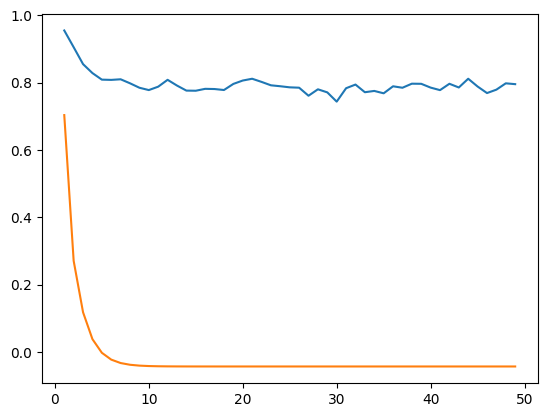

In [35]:
x = [i+1 for i in range(len(similarity))]
y = [func_cos(i, e)  for i in x]
plt.plot(x, similarity, label="Simulation")
plt.plot(x, y, label="Theoretical")
plt.show()

In [36]:
vec_snn = fhrr.bundle([rvs[0], rvs[1]])
vec_py  = fhrr.bundle_old([rvs[0], rvs[1]])
print( fhrr.similarity(vec_snn, vec_py) )

  0%|          | 0/1 [00:00<?, ?it/s]

0.9543430614237357


In [37]:
print(similarity[0])

0.9547695971849824


In [14]:
def convertAngleArray2Complex(arr):
    rad_arr = convert_deg2rad(arr)
    return phase2complex_array(rad_arr)

def findDifferent(arr1, arr2, delta):
    rslt = []
    for i in range(len(arr1)):
        if abs(arr1[i] - arr2[i]) > delta:
            rslt.append( [i, arr1[i], arr2[i]] )
    return rslt

In [15]:
hd1 = [77.48955844344377, 144.68631190172303, 318.3098861837907, 157.92662489824235, 358.996112237358, 129.6871424017255, 309.03872445028225, 278.4051482657061, 162.86463761535623, 279.7645484037223, 284.487485169227, 96.03717652209575, 288.78921125545526, 324.4381625882351, 16.310572623856277, 206.84396936130798, 280.86166427981533, 125.04535031227047, 120.82619045356878, 156.71712120646148, 225.75169232892955, 295.6438571366477, 161.30568556611013, 36.217306898282125, 101.6242985333138, 252.84986545932182, 19.415716541200382, 104.55434217715754, 99.19629417084889, 29.711563738374988, 124.12430570425113, 267.48729931410986, 111.99331413815935, 0.2864788975654116, 261.14758210156026, 146.31200079949522, 261.14758210156026, 157.7526968972531, 96.10160938121825, 113.54692729505018, 10.167118485481478, 51.673682822043936, 310.0420969322637, 115.00557911096413, 106.57697082046563, 207.74394312212587, 7.089833384448527, 57.15859887578045, 176.2947061940995, 208.9561616086153, 162.77210088943843, 259.25692087367565, 128.7545607035558, 154.85345814346573, 109.3848406129865, 92.44236772036514, 28.75716699110737, 40.908024784436904, 125.15460793595963, 230.65933781434106, 178.60280396846113, 341.86025962459615, 56.62757413825096, 253.52114828797488, 356.31703677290005, 220.878101438251, 267.237777579675, 196.89271310337563, 5.047552638759102, 27.905600775902165, 45.5089591049105, 129.27748085081754, 355.43287539132956, 106.02475853642177, 82.4637010838836, 237.54469118193336, 278.67597039436924, 348.93897389209695, 285.05362941832, 292.62400159899045, 358.996112237358, 352.80652409533445, 230.2885028660865, 209.72100846662636, 57.330177619654116, 320.44619414475574, 337.430974753135, 12.339718192858873, 327.03070498334654, 67.23278515968354, 335.8486489629679, 120.31873060286082, 72.10644288079828, 249.9815860082126, 110.05720229174477, 68.66704160244767, 5.052983465304023, 263.7927233567326, 188.59703592192994, 298.4155182973038, 215.5597423366528, 208.04567724430763, 196.62244170584188, 272.0597317810177, 259.72701501850554, 182.4706353919819, 357.6515575098772, 343.912241975284, 308.3734096506045, 25.153999259409222, 7.907665274522788, 124.93628328190651, 279.2191984068339, 11.0179953680786, 268.7419301739321, 141.8212364185206, 259.72701501850554, 316.20187369250726, 29.379437756682556, 241.34700721601646, 20.748815641733295, 313.43424241292297, 246.32751295392228, 248.67959858108648, 357.20560793692226, 72.8212754360477, 317.25237825626976, 283.923585297732, 348.5144739238584, 266.49199773526664, 49.08822782135223, 350.2187011802098, 292.62400159899045, 122.11376707818057, 184.23080229286919, 91.67324722093171, 351.0770803497692, 313.7775438832548, 42.37226705596978, 165.40352053430232, 47.572052069978675, 345.1552982715803, 95.42934629094323, 216.86517605254474, 244.644660602401, 45.84395864384888, 102.75426741944463, 351.5078497735112, 201.46195328088015, 40.87300578761758, 7.245843072701813, 311.39010604936044, 9.73689407808482, 303.15227255599115, 132.1397128991751, 159.9547166752717, 210.80124912833818, 109.34309067382124, 211.2676235733124, 58.909911076580634, 327.03070498334654, 91.17724301890885, 236.75941947554676, 169.91630935077796, 340.64078188515055, 308.70570858341773, 118.18436368210051, 355.87440691355476, 24.902546728564985, 17.86473544309127, 54.975800722589064, 83.06143739211701, 57.99167966911166, 73.04408402993667, 236.368727364201, 104.32589132025187, 227.18389973466424, 107.98299945925805, 60.65612906318264, 331.1894769542331, 55.06033011059227, 208.49992544789782, 253.2969916581889, 220.70793340940799, 93.31560181283766, 295.6438571366477, 120.31873060286082, 123.90955777050675, 73.23080203614816, 281.9674188635941, 175.1093505901049, 31.15594318275276, 127.49394640205234, 169.2137611136513, 314.1215982076882, 226.82414692431638, 191.88137814160186, 354.5530910463015, 118.42864719529211, 46.53653306780566, 98.21011229530737, 158.4507176799843, 288.78921125545526, 64.07490439843696, 231.40460223377352, 220.878101438251, 351.5078497735112, 335.4553835660558, 253.07323106485126, 168.6161845588061, 219.8610111783665, 70.2670830427794, 79.07228748700294, 259.72701501850554, 174.2572369619292, 357.6515575098772, 190.60472226574288, 250.6377056565281, 251.51790831028237, 144.0316227075976, 244.85375860291586, 313.7775438832548, 89.8334580010698, 265.9971193736412, 177.27654552315076, 41.39868461927914, 188.10170555837922, 21.55597423366528, 139.88227420186115, 36.629446051069124, 338.62753849339435, 251.51790831028237, 74.17889631419254, 314.1215982076882, 235.3976150907244, 36.61540101807408, 132.87518439954155, 137.53187593154664, 299.97790320985507, 245.06321434166946, 13.262297929050119, 156.37494408592337, 47.258148724086375, 231.0313690043642, 253.74570200656476, 8.421639108840038, 322.2484787012504, 294.42846615150216, 336.2428375180887, 347.6685650065675, 31.152555194150896, 82.55876010530594, 302.5120354439404, 175.8618155711551, 12.90038715564514, 18.03682538345474, 352.80652409533445, 101.48030377804166, 110.01493762112581, 39.877352110998274, 169.61450418319222, 42.61176521871361, 336.2428375180887, 164.35966584360966, 180.62982192018387, 119.06853597897407, 136.28872386556213, 269.50037400320946, 324.80600630999044, 251.29727856615057, 241.55050384941958, 253.74570200656476, 197.0281276240795, 314.1215982076882, 200.89684261249062, 330.80704106860463, 328.1545218389595, 312.06851586646144, 186.50969893581487, 220.70793340940799, 192.78526081117874, 90.83034165041586, 158.53840485080886, 93.28521574907575, 330.0448128633774, 91.90853306557959, 330.42548738801804, 312.74988817184675, 211.57968800990514, 5.253697987592137, 146.46160407229632, 151.41590780412878, 70.12947308822805, 277.59583097423604, 218.18651756695476, 206.09992630605154, 346.40737311416154, 61.9413832573863, 55.03917340353729, 235.01140079197015, 90.28644738903613, 92.71161733508467, 188.84568066276307, 125.26405665300028, 131.11162359973073, 47.14150033987355, 234.62645173252383, 327.03070498334654, 54.71331122334065, 59.83268537289299, 58.80108734922241, 256.0133132845501, 321.88640175888946, 94.5474909456804, 54.91257380973963, 29.533906965506347, 343.0885000783373, 295.9492743444335, 315.8532497964847, 62.25095557701252, 169.81558836123986, 128.696719481317, 18.207632996403433, 112.43284833807364, 292.62400159899045, 98.31122085292094, 32.01596977709115, 356.31703677290005, 204.627783975294, 42.91175817336903, 334.6716093053874, 166.75139555611852, 335.8486489629679, 95.2073438236662, 110.90936800828943, 115.14425143304325, 77.78411554857769, 281.9674188635941, 98.37874229581443, 327.77905899932676, 113.9534198748654, 304.1177256533032, 63.240374738501465, 143.454630728799, 340.64078188515055, 312.40883049663205, 138.46249278173593, 263.55004375842833, 183.75811261411903, 126.09106406928326, 34.04383809452307, 111.4703881577477, 304.1177256533032, 225.75169232892955, 50.11877144251429, 49.71002907607351, 327.4044543604704, 61.72783830325611, 205.21411000387647, 351.5078497735112, 107.61791794343036, 10.711894165622631, 242.36793364248018, 51.23013189653284, 143.59844489494316, 161.85248450023258, 180.85788987715378, 47.39889105979676, 292.92320814459265, 6.576801523575188, 14.077587103951432, 292.62400159899045, 113.00942704749966, 45.85863575562856, 89.30140198423057, 293.22302719080005, 314.1215982076882, 182.8199729198542, 313.7775438832548, 121.85406106567912, 207.29297942504454, 152.87027618218335, 226.4655316722621, 57.86283529901265, 22.14928850822728, 330.42548738801804, 51.935985780531475, 105.1298706662061, 136.28872386556213, 131.8963616783663, 151.17619924296127, 181.77595023186012, 258.7885253526754, 314.8119753466062, 306.06719825364485, 55.65939334863253, 233.86032454319312, 347.24714856413533, 166.07472322632557, 106.22131908246631, 84.40745361385139, 227.18389973466424, 14.353369285305458, 297.7951118143572, 145.79078756509497, 241.14385316953835, 263.55004375842833, 244.22753415636114, 217.52384021671344, 109.67798528537965, 180.0621606319369, 97.17737366533638, 274.6681664097907, 259.49175504113373, 314.4664078654353, 21.435009170625637, 200.33489340238575, 141.61092316629342, 65.42107731569116, 19.694685656909915, 138.39560268860464, 38.818278802901304, 172.2663244530437, 354.5530910463015, 254.64790894703253, 229.36661134140238, 54.011858515349104, 72.10644288079828, 184.23080229286919, 223.28830675402307, 64.81423021841891, 294.42846615150216, 125.15460793595963, 189.21987950159286, 312.06851586646144, 163.79582479440344, 330.42548738801804, 129.21916895147118, 296.5620057612957, 311.39010604936044, 118.67394265344309, 55.12389793446442, 179.498056118679, 187.24110951987683, 208.196873230677, 83.47287225099406, 320.44619414475574, 170.93012981229808, 42.82195778257273, 268.2386681324079, 9.910021363131715, 53.30831737354143, 322.9750818099342, 357.6515575098772, 283.923585297732, 218.3528182663198, 38.83932993023476, 97.90803061018853, 78.57347711613045, 241.7543439370562, 237.93928369220225, 100.90838237598155, 244.85375860291586, 172.05939793718414, 245.69373719160515, 301.8744969077045, 109.55215968084573, 277.058895130959, 158.8020496482326, 266.24432859239, 117.21722486309805, 33.07306598538578, 156.8887719416274, 300.92321172837353, 252.18212813856653, 52.953585501924515, 281.9674188635941, 53.189546521613735, 290.2521758514809, 288.78921125545526, 283.36191648408663, 175.00238091961614, 222.5943260026508, 350.2187011802098, 215.88462514349027, 350.2187011802098, 104.97577778138937, 15.291923644999018, 132.87518439954155, 39.184639251184734, 337.0339971357784, 163.88952949966338, 267.237777579675, 14.40461069818039, 132.50642810611083, 179.273402731797, 242.16305795892782, 24.71563260852486, 231.77904333771164, 122.89956995513153, 105.55596815232558, 119.31649211387406, 312.40883049663205, 19.435474733067277, 12.21918948882114, 180.0621606319369, 69.92406579580465, 120.77525192470979, 62.481766099326414, 359.44654650616263, 9.787458065097765, 119.76542540360019, 259.96270196498335, 115.88952166885582, 272.57744773112427, 43.71721311848186, 106.6563282075248, 228.8170108349933, 87.10212756625468, 79.31309456406744, 280.3120328428685, 32.50639936065035, 335.8486489629679, 245.69373719160515, 110.99531095134118, 104.55434217715754, 334.6716093053874, 93.95831340289, 261.6245639866773, 72.98825415679276, 274.1424857085279, 80.74377045248355, 340.2362203864746, 30.07336736987315, 212.99546287391198, 306.72258839979827, 349.3645092261117, 76.39437268410977, 168.6161845588061, 265.5040755935233, 207.89470070058894, 213.94988615788768, 23.67594194755468, 262.34331278883843, 17.49382618254834, 38.765750685441354, 89.88983293549157, 29.75476709237761, 171.23663930986947, 112.21265082859836, 96.81611948814181, 223.63692237737047, 234.05138689984608, 335.4553835660558, 126.14658633439525, 252.84986545932182, 355.43287539132956, 52.73911958126134, 326.65780794231654, 199.35901013598578, 284.487485169227, 330.80704106860463, 115.88952166885582, 345.1552982715803, 256.24230551467946, 40.02219859812959, 271.0301774507205, 146.31200079949522, 310.0420969322637, 283.36191648408663, 211.73606619764345, 17.213176564646496, 203.0325283950472, 287.9184900154891, 94.20549081401238, 74.9356258345309, 281.1372890730242, 257.1623856062941, 33.67962586002958, 240.94104084559427, 207.44308295829944, 277.59583097423604, 180.17540727384375, 96.81611948814181, 301.5567342793807, 183.28784233231704, 156.37494408592337, 110.353966704704, 102.7911365502015, 39.832994655924864, 358.996112237358, 136.54856890629725, 354.11483011793774, 213.79022206373998, 92.11540114643459, 298.10499226369575, 76.23174496152518, 155.69505302468022, 246.96456686673417, 25.87417788704946, 236.56391211016643, 45.954266532789795, 45.85129602519392, 186.6312036256753, 345.1552982715803, 47.730572736656384, 263.55004375842833, 118.77234559096668, 112.47699158437834, 169.2137611136513, 200.33489340238575, 12.820715934903182, 159.5094084439931, 335.06303808820076, 327.77905899932676, 142.38513795497596, 62.741764688000785, 239.73129503381722, 104.63071496180119, 330.42548738801804, 336.2428375180887, 205.36121689276817, 235.78510087688198, 48.53929135300095, 7.082821904354133, 105.1298706662061, 331.1894769542331, 42.34095441404251, 78.8546373700555, 321.88640175888946, 22.736420441699334, 91.96754335968271, 202.74515043553544, 351.9396775987858, 140.7758710395143, 296.25532323206994, 172.68167424075443, 170.01714989045198, 170.21919047261534, 0.2864788975654116, 202.03025216178528, 137.92917552499358, 99.5063902623868, 246.32751295392228, 295.33906965506355, 205.36121689276817, 26.54548717248069, 233.47913412013983, 121.595457370718, 157.6658764806888, 267.48729931410986, 273.88039920211435, 34.329406538695224, 118.8709118528679, 160.04407685218527, 83.741273769486, 209.41439880512544, 198.39258834169775, 172.7858248283544, 69.56748362443216, 120.62269371175225, 359.44654650616263, 148.74293746906108, 236.17386443974576, 31.845142014830106, 280.58657939805255, 305.4146029482, 273.3577266845531, 118.82160828096707, 357.6515575098772, 11.349744366919364, 142.8822431747689, 7.6154739105059175, 148.5116109722196, 150.69905184924335, 160.58234168464776, 115.98335933822332, 110.353966704704, 273.618813338502, 264.03585029070194, 50.01377401630789, 195.28213876306174, 276.2573747014577, 189.97274374364162, 247.60492442991494, 315.158303152268, 281.6901647644165, 26.248753671010775, 252.6268937966593, 54.91257380973963, 121.90591385762197, 258.32181926547486, 176.07799481586454, 327.77905899932676, 97.57455639148897, 79.48915026787226, 254.4217562747883, 215.39766734241474, 108.51473392629228, 94.11264703200119, 185.30329726093893, 99.61018691425994, 86.18498723387833, 111.86212321960626, 114.86724040313216, 325.54420177887687, 194.22298140027902, 260.9097427735989, 344.7399489355133, 324.80600630999044, 139.60959920341696, 218.85324489336256, 308.04182533915224, 126.70451020142045, 161.30568556611013, 59.47247198783716, 63.6336955942718, 253.52114828797488, 249.54607801865123, 6.447870753216557, 129.62846043683783, 238.73241463784296, 36.90311703792498, 285.337547375908, 48.979124220449926, 208.34828913848114, 175.7539248867556, 72.05203661101902, 315.5053937945062, 201.60372805447682, 341.86025962459615, 274.9317634984756, 185.4232346701693, 203.89957122093352, 18.24473936857799, 86.96991425786632, 230.10353218105354, 38.09559808050687, 333.50279111223705, 278.134852005254, 330.80704106860463, 290.54654925498136, 19.451310263811216, 165.88239581089266, 48.25314090709308, 22.936661134140245, 162.77210088943843, 105.43941758020303, 59.54664260349442, 147.28992162746098, 52.57458204540495, 157.23320393271766, 302.1929299213203, 56.36020018992949, 327.77905899932676, 328.1545218389595, 235.5911986557661, 314.1215982076882, 287.6294152263169, 195.68230708019917, 225.21925909230467, 43.97220223567331, 243.60450473249284, 349.79108371845126, 12.383992459491274, 341.04630662549005, 347.6685650065675, 268.994270014471, 109.4266224466813, 327.77905899932676, 158.97830053574452, 242.573156278926, 209.56759148896236, 211.57968800990514, 79.11596176896205, 235.97932254152522, 292.62400159899045, 318.3098861837907, 267.48729931410986, 82.25061658495882, 346.82675250049834, 309.03872445028225, 5.35244469789458, 19.873666150913053, 263.0660216394964, 104.82213595514513, 117.31322586626192, 58.680642680338316, 57.79279757220328, 27.16727335850276, 287.9184900154891, 233.28900453209417, 235.97932254152522, 193.04507922197544, 205.5085348388892, 220.70793340940799, 225.21925909230467, 115.56228219661621, 337.8288886384571, 35.27630803662254, 106.81539804825191, 16.2026411156276, 6.790530424893609, 25.464790894703256, 72.32489208922283, 57.89791785881399, 235.5911986557661, 256.24230551467946, 274.1424857085279, 128.52350720745247, 297.1772796321697, 57.15859887578045, 74.68167298368394, 323.70496900046516, 291.43326303704134, 103.7591081366938, 12.963432624345518, 183.17065061727084, 67.5020965045739, 101.84105850174603, 241.14385316953835, 324.0711510920946, 333.1149971690832, 130.75257761999617, 34.940711985048374, 202.88873765255778, 252.84986545932182, 231.0313690043642, 266.74012808697546, 81.71103752578767, 121.595457370718, 289.6652149296376, 154.60275097971484, 243.60450473249284, 85.41410183822649, 322.9750818099342, 146.61151359540003, 13.416330144027144, 349.79108371845126, 28.803428269194814, 346.82675250049834, 174.3632973617843, 42.69432154477073, 140.84508238220826, 67.21701022182346, 237.15140526938046, 291.7300382539833, 27.13896339194881, 56.56049310274663, 141.33147388525487, 114.77519934511683, 58.89779966394153, 239.73129503381722, 12.46102207766036, 161.30568556611013, 286.19270486055103, 268.49006332278503, 129.3942626763377, 146.16270283949572, 125.48352937600157, 219.524059437097, 341.86025962459615, 227.18389973466424, 90.9168192844848, 82.72564180346856, 109.34309067382124, 158.01373279945483, 89.30140198423057, 271.0301774507205, 222.24895078775143, 37.30193978716297, 136.94019960105717, 216.21048872861252, 168.31897624289755, 119.66537074578598, 42.9890302469105, 40.82058956474945, 177.6062601149483, 220.0298752422516, 122.53160717083473, 161.03366923294638, 238.53363660733686, 228.6343955031218, 178.93747505647195, 217.02946785258453, 7.81789372244874, 9.872114737427603, 319.3744677429338, 57.50278955548207, 97.74100906360002, 335.4553835660558, 10.99853716610019, 28.327785777258143, 133.80611749902457, 251.73892580440386, 88.20163102383361, 305.7405523643667, 290.2521758514809, 71.44112158738444, 298.10499226369575, 9.213910252328947, 171.54425003916865, 307.051337154782, 337.8288886384571, 19.944228457630995, 76.4963678412314, 98.41253781017231, 130.395492747115, 44.95902347228682, 318.3098861837907, 172.57764913579015, 139.1349672488643, 184.23080229286919, 165.69051334031903, 342.67810713565984, 336.2428375180887, 327.03070498334654, 153.6903956895985, 318.3098861837907, 329.28608915564547, 259.02251136113165, 269.50037400320946, 191.2409196030785, 224.16189167872582, 52.37274178526721, 144.8326074648188, 331.95700760766124, 333.89148900397623, 83.86384589151395, 248.46391809662757, 225.04233901446312, 270.51831687007706, 49.07141102525036, 351.5078497735112, 153.2792389328045, 26.219924726836137, 144.0316227075976, 217.1940087683181, 316.9014353599686, 260.67233627425986, 309.37245957387864, 180.5160035068756, 99.81843120746049, 22.887185233315613, 204.627783975294, 136.09448815458984, 65.48089087209408, 123.16375647696114, 32.74793067734472, 75.88844968620175, 91.38082856950929, 140.9143618127947, 268.994270014471, 264.52345112226374, 190.9859317102744, 144.39460562772763, 142.38513795497596, 194.61881628085024, 160.85283411870387, 171.33905356782992, 65.61587209468887, 221.73289285248575, 330.42548738801804, 99.7142003360291, 327.03070498334654, 16.356203115353217, 291.7300382539833, 181.54556246223802, 113.90811036398077, 145.86501912699165, 147.66953482753178, 58.144692016523564, 159.86545623069847, 113.14332447291139, 314.4664078654353, 305.0893477799911, 310.0420969322637, 30.13663976072077, 22.34276224968114, 277.8650800828435, 6.308301534041169, 235.5911986557661, 73.89190032638938, 213.47160772385365, 112.47699158437834, 227.18389973466424, 14.20955793687871, 171.956120987642, 235.20434939688965, 348.0910055472802, 329.6650144596221, 59.11656986492192, 293.5234606202988, 248.46391809662757, 255.1014225871875, 187.60897024584912, 263.7927233567326, 147.66953482753178, 175.00238091961614, 123.64216554398429]
hd2 = [49.293440194157654, 157.97931448363434, 184.06694876687007, 68.67216803267124, 153.96569010593836, 168.14808618205, 175.22160091046354, 39.45090070101811, 10.590025198667115, 167.48257958958783, 348.30030103800215, 28.80138134818334, 237.36237273866377, 116.73319087576996, 3.6698850207391795, 120.47689998400607, 182.2680125952764, 98.69023041928094, 259.6596154113059, 118.84217735251539, 62.77792174820306, 154.408285965313, 212.0995350764972, 253.79811596962116, 80.79857834460769, 260.4318200062802, 25.168761268235894, 226.46784262438916, 26.907276852919804, 105.2316665588667, 1.508720107658784, 330.05612247635275, 49.56774735801677, 161.89837513494993, 224.04037385086616, 4.988442333852258, 307.60354166286214, 105.6462235875426, 63.50022669181283, 338.72230123437237, 43.21855235794597, 82.71897200529372, 70.11509431314379, 137.17279578885064, 32.951048175605024, 153.40050920770338, 31.658151221875297, 320.01257146343596, 181.721610355425, 64.90837547056493, 347.4984798466209, 15.200501220546014, 55.57476318636675, 123.27200165360146, 94.65365893881427, 228.89780825733132, 91.35012900095222, 304.08991893308803, 121.35681228924112, 300.19247792639374, 196.65764861779286, 110.18887974601721, 304.59106387641367, 269.97938863332905, 317.9478411746815, 72.7385611981749, 182.121558516121, 83.23628040849641, 266.8704704888155, 233.1577566778618, 30.08271378863159, 178.13300052727791, 293.1670663301022, 15.589802300140322, 348.5860749767545, 279.13506381663717, 259.0661935236608, 339.63908774363216, 208.80661648679208, 130.96304656664879, 180.64127963078963, 267.40572878130195, 47.47437973168644, 240.17116892872772, 228.7097656257503, 139.8076995574802, 152.90114737054387, 90.83753132572686, 227.81211757763515, 252.73992041475475, 18.66344049386042, 273.17904887955655, 12.396869837376515, 143.5842413628706, 79.26196306035487, 106.86619510570017, 187.46170822790546, 93.01771801416471, 144.72091575849973, 239.833420938704, 30.023376935161195, 343.4526588006904, 271.1191762261648, 192.77715947335068, 210.37009594416122, 235.9069753777441, 202.34166560033677, 242.75983255933403, 153.240373356764, 191.64126312143765, 86.36891280078778, 64.4542207463685, 113.59267525551795, 343.5914789111655, 256.6226900740517, 168.8099345673344, 267.40647594904607, 84.4947148392062, 349.97889553256385, 348.0225757622107, 324.2177857160237, 309.8257172232197, 104.32647907472747, 223.3718686608846, 42.235093337725374, 337.17752024581296, 287.89680679587036, 285.6843774503773, 184.1589736222447, 349.0888712951391, 51.06074963315655, 299.6233713614826, 37.28502584517123, 277.3763238125506, 7.486684973964401, 177.65996285312053, 134.97985055750544, 70.90314669623073, 229.5110659224239, 44.196516523750915, 2.9941389369134908, 163.50236991602821, 165.95583703942688, 93.92887092664495, 220.02169892087286, 29.67576734473583, 55.548675485620805, 285.14525384685373, 331.02740326577737, 101.90535701481555, 200.9552884273395, 200.07657130788596, 322.82996272500156, 50.0629758682513, 171.84919336587876, 314.2609402427463, 5.801733211722582, 222.7526337664063, 86.22311053555728, 221.78730323035904, 193.6093719215867, 15.508813865652144, 92.92435275522625, 311.13660327034495, 341.92632951321775, 159.23262637299726, 104.61818015950058, 338.5818285690205, 77.54570747630552, 354.92351707478736, 294.40926404512857, 269.4210189222132, 134.326663247501, 105.70699772287887, 240.40269577315516, 300.9320484108771, 249.6208931093418, 137.44912785207956, 127.05265113789511, 113.70008067350099, 165.01731946319558, 97.20920540550713, 200.6851907018286, 307.49741306756715, 238.75756985573994, 331.7311928023309, 103.414846463523, 208.33483865338397, 166.11713990024197, 324.71583726479804, 347.6132053258005, 140.92323442964516, 212.55148255252521, 263.11984966367345, 131.11204808900388, 95.63317830832352, 34.7625696358522, 241.38812251156173, 271.2408736506246, 215.16058576421423, 69.88060102800877, 27.291738522690025, 69.78779098847599, 295.025716022821, 171.10298515858634, 256.2466622224041, 7.121268254360016, 158.66833088785404, 358.5844340386943, 114.3401759998747, 133.7581643072717, 324.8288828349601, 347.113548509652, 101.84562181610457, 338.3764803593208, 162.32987368479974, 81.32334551556059, 193.839978445683, 36.37589666132697, 6.927208254815894, 48.982243195140406, 224.85930799942037, 66.86515665382667, 172.8112754903271, 125.21545290890556, 146.73470184001286, 107.24892866176971, 130.82518419157972, 98.03135284196037, 266.7648907791705, 114.1906946633613, 201.08280262926286, 13.341951143709943, 44.69166565426869, 44.023062891884045, 261.54292476308166, 198.96792891826857, 205.0064784804043, 36.74818576553669, 0.16772403596759267, 253.90155300275512, 341.6628106727027, 218.50772312728384, 110.40799335794047, 67.7759143524979, 63.969859768974885, 311.12235182018765, 55.35389605332417, 68.39834113239799, 245.93428138555427, 12.943688999976327, 67.60773307610282, 345.2913855305567, 61.966391523370724, 351.94919963080065, 347.82476364225374, 171.58211671425593, 104.55563545378061, 328.03447931694456, 300.356815260424, 97.06289918414805, 232.01084125104288, 19.07963007394156, 233.55958784310926, 346.2400470003707, 267.9471900005416, 114.44466391283399, 190.7381893817878, 324.6859005231883, 354.93763354039726, 357.85511345436765, 145.4659452436322, 251.5557532948686, 151.60436510837596, 128.98308991942716, 267.9467369676776, 128.49529198725838, 323.0832144471269, 49.11138973437913, 308.92640393819283, 206.36632539183373, 237.58229040054283, 348.0289115600638, 267.77118705507695, 237.88094349309702, 322.2402972265494, 319.1311860802683, 293.0940187529083, 275.82918212807414, 323.83572530053306, 119.67005926589553, 289.8266830697052, 196.53349235121198, 81.23574574876474, 333.65970812134765, 106.48336876494145, 4.960757148444973, 151.76073384335731, 194.65410844958393, 181.71400792126573, 228.18086093072617, 325.42516233612656, 318.9226374031997, 257.30311860530105, 323.8614313234418, 32.82070377889003, 182.55010878221978, 274.05275539060165, 198.4092365527516, 121.65616496811323, 188.33809667505048, 294.1900353731947, 129.9058590741919, 190.0381741592425, 351.68004262855777, 198.55969368191236, 319.6144357798952, 169.94959414210058, 92.6976508621635, 326.15050285901776, 248.39057742226254, 236.2950781838825, 147.37203669505715, 222.5417069598898, 148.14400149586433, 146.67107380355307, 264.89734080899893, 276.6061273012604, 183.3655703892081, 0.5442309010515233, 207.10986078669043, 77.99011854668503, 230.19745052861026, 92.21148090707186, 80.88045686575897, 303.02050058984327, 75.21325376435433, 57.579208913885324, 42.29829951397958, 166.65061883009832, 330.8303071272121, 188.14815437237206, 107.07311862813168, 235.09486335510087, 320.9066494777201, 107.58486603749631, 327.7017918946415, 17.201361402564523, 126.63331237562333, 185.16912380705563, 89.77747770389553, 120.21380857640466, 171.69500817503987, 2.441832184231842, 130.258443748278, 50.48803557516129, 250.4773963519157, 142.7317676643021, 269.3626907647366, 28.924426812908813, 42.35049771949912, 293.7975464822938, 237.3137144539523, 9.750748697396595, 303.2066990492286, 66.28442191352812, 74.68779682529997, 269.6615910963322, 175.69295614460063, 192.15238359188152, 88.45461886991654, 138.59842926595874, 81.15463510650005, 57.521651128697435, 196.37761936380187, 61.94090804435112, 308.8351912174965, 220.73659983871786, 46.39353772445113, 166.10187636957377, 25.409482504739714, 204.58562938913371, 255.37997392770345, 337.74202285656617, 256.7079722194556, 30.807835966151174, 302.97372537175534, 204.13604478574467, 304.8144152796607, 58.51362166707831, 163.92003130560462, 319.28044542097257, 194.98955997701734, 209.9438079267353, 152.22132785886896, 84.81020562849557, 58.38308196628444, 217.71180140328227, 119.2638708785039, 62.91012362858168, 49.02672003588955, 106.35967286806496, 1.0564758565145118, 255.37304425810524, 352.67738400426356, 247.1854160484593, 252.15654902406547, 353.43325469110425, 105.04682605274347, 245.3660697805833, 99.62048910989829, 351.2808421334611, 348.09347545915955, 23.14129121628449, 197.61362479646078, 215.4524801090257, 290.74395291087177, 149.08634448831623, 222.08566697329985, 236.7652358296927, 14.805178578258618, 135.36769223907308, 267.10197306241827, 154.47514105407217, 303.0207828922925, 258.21461010797077, 177.8628599673817, 320.06290381159533, 319.6527261721136, 85.44784288979575, 263.38102331660133, 356.08610254147993, 230.30047853784146, 84.48483986971694, 205.99558071065948, 170.74947906953582, 176.87039455083138, 146.11163920066875, 310.86505735786454, 160.22906384341908, 21.33002139627292, 2.9779512073689163, 327.95107656110144, 248.2315423139111, 262.5574905008309, 284.69015616752, 28.069817869587695, 327.6866306946095, 105.11148104065212, 186.20889655537607, 323.03717984799897, 86.3418567805703, 336.7786945201595, 28.915757258204554, 54.1073574295535, 213.16744646599895, 73.70303617019474, 113.67055173388405, 289.82015359137375, 108.87839094159577, 287.905981135665, 106.75361545664647, 28.148706579102573, 87.2273708531879, 198.18051453906844, 277.9962791900172, 312.7145079072747, 6.620178147477295, 18.245420547740107, 133.28869291222907, 255.14748376912357, 260.0879029700042, 351.5130261253936, 191.696576140382, 178.64963421870686, 253.01778439608444, 200.29101743960825, 227.6449808904437, 85.17107620498184, 202.62827320596114, 69.29426025474214, 5.901464557682379, 118.01992077649693, 270.8364012765122, 228.24318069557603, 33.52230598933098, 247.97192861165632, 215.7316019989015, 265.8637748979381, 315.22026866429013, 69.4401254944632, 337.0853110991783, 52.90993097153584, 254.43410539182568, 24.791995555837744, 336.97873676512455, 151.61677741021674, 5.497055831018937, 249.7780723235627, 187.43505352462023, 95.68047592704067, 75.69370687291745, 189.37365452794268, 20.111262719397015, 336.54436070836834, 186.7454714042052, 42.672588585926405, 295.1710044292771, 278.89464256852347, 263.20059375545566, 52.472282424342595, 241.8279927661191, 280.05113882769, 77.59796971232475, 255.57159831229154, 228.39241160527195, 48.09537235559053, 8.400324293285813, 269.90163669787484, 233.02786105024117, 59.62446990596048, 333.3977617412114, 66.1766026707971, 232.2258775345968, 281.52241225911337, 222.018058353335, 212.97751766625885, 198.02489663016988, 286.0933052783485, 153.70223854517462, 317.43479339003994, 165.69532308305992, 81.61997373336415, 200.66320232479367, 188.57624564844403, 326.1368091609931, 297.7943242706967, 36.98264585694399, 142.656157195476, 101.44736425402634, 257.3275690185828, 128.8443983452216, 146.87052195110297, 303.3411274624681, 338.9978584017299, 317.96564700052204, 124.91589880908211, 39.37755441359871, 293.30944584140286, 195.6399997728661, 16.799922897752317, 192.73435602301632, 170.69456256605673, 16.071575300777102, 102.41963691929854, 10.014363555333665, 294.9150664826274, 159.92745270793074, 125.01727395618455, 182.34456976122814, 139.72730753920476, 193.63137331973704, 261.0883055435986, 122.37800861023086, 272.03375995837405, 5.007334158072689, 145.45525772385741, 176.58669459651315, 337.78504955591234, 168.86092764475796, 328.6715955585746, 127.01156014300689, 345.7734208186622, 125.19865346063057, 167.1022065422126, 47.11239224206979, 264.8789997351908, 242.3083978958117, 328.77810227209494, 262.6024737656742, 53.8460883111412, 125.50669989471581, 186.9158260285745, 198.9505537125795, 303.41214872777743, 159.14332313642203, 315.7671169896784, 50.82872899373454, 155.04473083276534, 160.12953283727313, 166.60358436798757, 43.6046315932049, 244.12215724649406, 45.337113558533154, 116.83620482192089, 151.88519039160653, 353.3046374744271, 206.24836444121922, 165.75191406844633, 160.113854376816, 64.90073764183992, 124.69659989845886, 59.307931274925274, 106.34045987985517, 18.09849000086379, 138.1565928518872, 22.04700945037922, 85.57376901349929, 34.595921238449435, 291.3476311711702, 239.65405685922582, 37.91952199491226, 230.49520467123207, 240.6721337355741, 268.15487951649646, 237.71479780395305, 331.2414595123567, 349.8154040992479, 92.22535828255252, 119.4422380671391, 258.7758955674325, 263.23849515585766, 348.3166643733984, 74.367670055774, 291.4721813451826, 144.5614889355726, 303.3235719474916, 259.196738061339, 246.41396614791446, 171.07147500486218, 214.3274229347488, 330.13412662556715, 20.73172655789254, 336.351602819338, 41.10238023795873, 103.53673330662359, 247.24441858860362, 251.34056994382993, 348.2070521419136, 2.1848717620987532, 34.64631832133599, 12.77572402525664, 254.9505195733443, 195.5570415694966, 95.86402411848755, 49.038744880354024, 90.64336713674672, 197.3582168935518, 198.29566748233222, 134.95277866872812, 90.16087484391463, 311.5601569432001, 326.63284467824013, 310.92941560854064, 333.41918905785, 22.36832790260929, 295.85087458252144, 112.65210320413524, 225.92139751103971, 89.99294924801129, 294.6137726556976, 27.098129039518927, 82.04355208627733, 108.29754646919844, 17.823432537527857, 66.24712744967528, 73.5064563882213, 210.0522440554253, 348.8395246091352, 152.8518841254205, 337.64332232931355, 334.9574029209536, 89.87873145308487, 93.94255759102204, 332.97129356080217, 117.69241225690895, 345.4842610659278, 29.10686305045882, 177.51414360071806, 319.11495016595666, 171.65590234030782, 121.09919280432223, 148.4382535364879, 146.77715968394318, 146.50007257633095, 112.53208730583623, 338.09359287831194, 230.7791450016605, 37.567892718668126, 304.7495614852209, 115.56379943487563, 88.52816468417166, 28.987567481336292, 34.97838740536133, 196.79589964877644, 299.75796658124796, 34.27992618870424, 226.95363458270853, 267.1351493968011, 129.95565360784994, 333.34746297999203, 130.50044734745845, 208.72221990191449, 211.23261152416578, 229.74041078850613, 71.8433796753258, 266.93711729502286, 101.03794042173791, 152.0100364575756, 355.48523976130247, 7.370048542799224, 218.50363263988527, 109.47035921189784, 157.77678440417483, 85.48404805730443, 163.24634070886148, 46.32533359409666, 307.63236423044077, 197.6701716952893, 113.66399917850968, 205.14358726429734, 321.6310304343648, 270.5810258513661, 147.93939203759018, 54.93498818566004, 235.14206278775035, 242.90535812079673, 85.90429936640837, 253.16824244996448, 201.2005132442061, 225.9327137112725, 129.10783520238297, 330.6031371662225, 154.03463014855686, 44.02328569660325, 171.93314131920766, 305.82408930827796, 159.51409490941597, 164.11326537047563, 343.77940790010535, 67.98983560515225, 334.6634602033618, 5.896933295396382, 336.44020113700117, 90.16440371329513, 174.91329634977876, 102.50622243013714, 43.31749727259326, 324.7790941386508, 214.28508202691324, 192.9720500178893, 313.54614382468986, 129.6861891342053, 17.157435026957298, 106.81888868856007, 322.7799451996629, 274.7308792380569, 190.48672141116697, 99.7476079472256, 137.9167745737381, 346.6211076032102, 242.20746881515524, 76.15661760270609, 109.62406368504105, 184.25515056361866, 11.917471797469938, 315.99163368540377, 268.9794752328081, 45.23992279191736, 75.88888576076599, 62.244063688329646, 286.44825905297563, 11.1956983170567, 180.88674968627626, 171.78412529332792, 320.14455985353067, 339.7606602562676, 342.8692301019659, 265.1479070074094, 242.4274228854426, 79.14447887183428, 275.40436154783447, 283.9305467873537, 188.4046926259772, 254.6384024524484, 250.23158527703475, 256.8173748581526, 263.8357911793291, 347.66421900121486, 126.43544816949918, 150.86737643657398, 95.10146051909915, 274.3305173865593, 213.26941888588456, 300.38932415920846, 21.82462707870844, 76.69541204329202, 304.8562967866394, 53.96986714363778, 42.20693991856962, 314.81170967901767, 105.85912760636019, 198.6286016433927, 132.2188120233435, 140.04869831787968, 161.54122463267095, 65.84198777375234, 142.29748435366622, 54.64586947751849, 211.46594947189692, 191.40524146249425, 217.52154629072854, 150.83704213694455, 316.51439138024716, 47.95552038733125, 72.42006058519495, 55.91393465975525, 250.78459307488808, 61.06422465157681, 297.61885248886017, 158.95586984860026, 233.95325035797512, 135.5177000535761, 46.92314502386029, 309.999045283602, 2.6737870608259953, 353.37297196817184, 69.63180644817258, 156.39088873130015, 296.30032722477426, 129.62539879374086, 168.69725648570335, 246.33751445086688, 146.29212294631932, 212.2578823000266, 137.41818025759076, 251.82130087614715, 355.40223615099814, 33.77064593281014, 47.60645938626524, 247.80248373146384, 97.26460141417505, 290.2640963079125, 55.620920214484066, 290.7709648289775, 310.90340929621755, 59.49403112535466, 23.87994088176253, 309.3848895625442, 281.185946364244, 346.69676294027647, 41.498704799834805, 260.73288114097716, 66.81495295880427, 181.10976571844208, 165.62208585700543, 2.936013192164413, 181.1869589934741, 54.88352141543377, 255.65121956826496, 118.0966057040394, 1.2489657259500315, 102.49259875442031, 323.1788461260452, 50.27566401265351, 251.8640328979798, 194.94061333800508, 264.1311963555737, 186.84225934694703, 157.09181975675187, 251.32026823585093, 104.44560188359937, 9.017058804269375, 9.774365434871731, 129.07126012285252, 320.46204506164145, 177.08097616088097, 325.375156084165, 208.53799200162027, 22.459511544777595, 231.5066808642302, 279.6413112379381, 311.68296156179395, 160.15876508301497, 44.637018419558885, 109.82251237990472, 250.29524676553243, 239.96098898668325, 344.1007376056755, 269.73711955631893, 168.68466310312013, 238.87743204619338, 173.85429628194058, 273.80949709359294, 218.05955368611814, 41.21318547324962, 144.08957258198174, 209.1066441501218, 100.16120749186922, 76.96231597095985, 40.8610799908058, 266.61645691063774, 90.09166953176172, 325.42920462902197, 180.54646226385526, 62.09234709487686, 44.54482035487432, 15.867871887099202, 39.194433806791054, 168.62654644903125, 134.60243578518498, 74.26956811035225, 73.75303531093292, 271.43274847981985, 211.03374208223113, 156.73078911632206, 306.9174494403785, 163.826997029931, 345.06999634181363, 148.6206018300443, 126.94868917297808, 59.391112417205, 142.4577824457857, 175.56222788150558, 354.22563953070346, 196.21102890703548, 174.466131090703, 327.9864208321483, 325.8581417747172, 346.6775056653945, 351.10112856213516, 353.3666775236023, 82.97856430338085, 106.64139454588154, 119.81187983054741, 241.82610116808715, 242.82693487031528, 108.76587213309641, 81.92289881710069, 340.0574698244193, 268.57354119815176, 341.5090349018621, 192.2967167550867, 172.24644701453354, 214.97833244425465, 264.7684280818982, 163.07919374328293, 349.5368456721201, 198.2556015670089, 259.14289707563574, 31.118428328219444, 320.95068181070667, 266.3760958074201, 54.70727963269244, 43.60776039734627, 158.4884870253028, 138.57167156587622, 30.57938574073118, 110.25527341719192, 225.4842285011717, 343.83600954634153, 224.31234112565681, 216.01418431684067, 240.17294289443757, 128.25542006946762, 231.48335200490135, 175.71495181135433, 145.42690624541027, 92.16912532371546, 172.78649683816428, 169.91154233437467, 300.4991554108473, 148.90992532551866, 36.20513942829449, 122.14970435628327, 235.55721336294104, 175.45827675902595, 140.66712685067154, 330.5294709639162, 288.00963708116774, 133.25480000307948, 73.10846261771646, 292.91462841709466, 195.30025667598264, 59.254515257581716, 19.342072010630552, 359.3507953503515, 70.93491370696151, 26.3413565938542, 16.064329251647, 197.99723955015693, 199.71504780147822, 270.77840005788784, 223.3966995313742, 237.43997911833296, 32.61594295447577, 192.98207918349337, 346.208646791892, 264.6338722110879, 202.97390397482388]

c1 = convertAngleArray2Complex(hd1)
c2 = convertAngleArray2Complex(hd2)

## Experiment 2

c1 = rvs[0]
c2 = rvs[1]

hd1 = getAngleArr(c1)
hd2 = getAngleArr(c2)

In [16]:
vec_snn = fhrr.bundle([c1, c2])
vec_py  = fhrr.bundle_old([c1, c2])
print( fhrr.similarity(vec_snn, vec_py) )

  0%|          | 0/1 [00:00<?, ?it/s]

0.9936811624349021


In [17]:
print(func_cos(1, e))

(0.9335684868483424+0j)


In [18]:
angle_snn = (getAngleArr(vec_snn))

In [19]:
angle_py = (getAngleArr(vec_py))

In [20]:
rslt = findDifferent(angle_snn, angle_py, 5)

In [21]:
print(rslt)

[[10, 28.3, 9.4], [22, 337.0, 345.0], [28, 305.6, 312.1], [34, 313.9, 319.5], [48, 297.6, 302.8], [60, 290.1, 296.7], [68, 327.4, 332.5], [82, 322.8, 328.0], [95, 305.6, 310.9], [106, 293.8, 299.9], [138, 347.2, 356.0], [154, 260.4, 265.7], [174, 342.1, 347.4], [184, 318.3, 3.0], [193, 358.1, 1.1], [200, 293.8, 301.1], [218, 286.5, 292.8], [219, 309.7, 314.9], [222, 309.7, 314.8], [230, 352.6, 2.6], [235, 342.1, 348.5], [243, 322.8, 330.2], [246, 313.9, 322.1], [248, 293.8, 300.2], [256, 322.8, 328.7], [261, 347.2, 5.7], [284, 352.6, 358.7], [288, 342.1, 349.1], [299, 290.1, 295.4], [307, 15.5, 8.9], [308, 352.6, 357.8], [316, 352.6, 357.9], [319, 332.1, 340.0], [364, 20.7, 25.8], [370, 327.4, 337.7], [371, 347.2, 352.5], [375, 17.2, 6.2], [386, 337.0, 343.5], [391, 0.0, 8.7], [404, 13.2, 3.7], [410, 81.3, 86.9], [416, 337.0, 343.3], [442, 272.8, 278.8], [444, 337.0, 342.1], [447, 342.1, 1.2], [464, 327.4, 335.5], [467, 21.2, 5.9], [471, 313.9, 320.4], [490, 290.1, 295.8], [511, 38.8, 

In [22]:
def angle_rad(a):
    return a / 180 * cmath.pi

In [23]:
print( [cmath.cos(angle_rad(i[1]) - angle_rad(i[2])) for i in rslt ] )

[(0.9460853588275453-0j), (0.9902680687415703+0j), (0.9935718556765875+0j), (0.9952273999818312+0j), (0.9958843986159704+0j), (0.9933727656003966+0j), (0.9960410654107695+0j), (0.9958843986159704+0j), (0.9957246981845822+0j), (0.9943379441332046+0j), (0.9882283814465528+0j), (0.9957246981845821+0j), (0.9957246981845822+0j), (0.7107994738729921+0j), (0.9986295347545739+0j), (0.9918944425900296+0j), (0.9939609554551797+0j), (0.9958843986159703+0j), (0.9960410654107695+0j), (0.9848077530122082+0j), (0.9937679191605965+0j), (0.9916711623830905+0j), (0.9897762309077889+0j), (0.9937679191605964+0j), (0.9947028171171743+0j), (0.9483236552061991+0j), (0.9943379441332048+0j), (0.9925461516413221+0j), (0.9957246981845821+0j), (0.9933727656003964-0j), (0.9958843986159704+0j), (0.9957246981845822+0j), (0.990509463238309+0j), (0.9960410654107695+0j), (0.9838850379335415+0j), (0.9957246981845821+0j), (0.981627183447664-0j), (0.9935718556765875+0j), (0.9884938868086836+0j), (0.9862856015372314-0j), (

In [24]:
print(hd1[1])
print(hd2[1])

311.3
192.5


In [53]:
def isInDangerZone(v1, v2):
    opp = v1 - 180
    while(opp < 0):
        opp = opp - 360

### Behavior of limit vs V_th

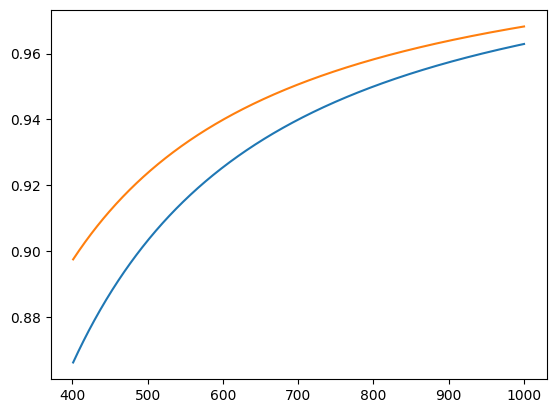

In [52]:
v_th = [i+1 for i in range(400,1000)]

E = [(4 * cmath.pi ** 2) / (2 * cmath.pi + theshold) for theshold in v_th]
y = [ func_cos(50, e) for e in E]
y_2 = [ func_cos(2, e) for e in E]

plt.plot(v_th, y)
plt.plot(v_th, y_2)
plt.show()

## Binding

In [88]:
def correct_binding_error(arr, e):
    max_error = 3 * e # Each binding accumulated a worst case error of 3e
    amount_to_add_back = 0.2 #max_error * 0.01 # in radians
    phase_arr = complexarr2phase(arr)
    corrected_phase_arr = [ elem + amount_to_add_back for elem in phase_arr]
    return corrected_phase_arr

def binding_sim_theoretical(x, e):
    return cmath.cos(3 * e * x)

In [62]:
N = 20
rvs = [fhrr.get_rv() for i in range(N)]

In [68]:
# import pickle

# outfile3 = open("rvs_binding", 'wb')
# pickle.dump(rvs, outfile3)
# outfile3.close()

# print("All saved!")

All saved!


In [89]:
Vth = GlobalVars.global_threshold
print(f'Vth : {Vth}')
e = (4 * cmath.pi ** 2) / (2 * cmath.pi + Vth)

vec_snn           = fhrr.bind(rvs[0], rvs[1])
vec_snn_corrected = correct_binding_error(vec_snn, e)
vec_py            = fhrr.bind_old(rvs[0], rvs[1])

similarity = []

snn_result           = []
snn_result_corrected = []
py_result            = []

similarity.append( fhrr.similarity(vec_snn, vec_py) )
# with nb.tqdm(total=(N-2)) as pbar:
for i in range(2,N):
#     print(f'bind  : {getAngleArr(vec_snn, False)}')
#     print(f'rv_i  : {getAngleArr(rvs[i], False)}')
    vec_snn = fhrr.bind(vec_snn, rvs[i])
    snn_result.append(vec_snn)
    vec_snn = correct_binding_error(vec_snn, e)
    snn_result_corrected.append(vec_snn)
    vec_py  = fhrr.bind_old(vec_py, rvs[i])
    py_result.append(vec_py)
    sim =  fhrr.similarity(vec_snn, vec_py)
    print(i, sim)
    similarity.append(sim)

Vth : 400
2 -0.013172934972490231
3 -0.0333537159844192
4 -0.02996143699737251
5 -0.02184230740068969
6 0.014068604907240335
7 -0.021875355416650463
8 -0.008442026661065576
9 0.02451253037567526
10 -0.018449833135204607
11 0.0010957156475757388
12 -0.02114555432091917
13 -0.009944881234794235
14 0.0037265947734569003
15 0.012538514436703896
16 0.0005530336721158495
17 0.012725764023098635
18 0.008343380579734447
19 0.02226808072397744
20 -0.027149486246430217
21 0.0016636525537274281
22 -0.02998855894111715
23 -0.011896534532041717
24 0.018819164415182065
25 -0.016535868496082275
26 0.005295015954282535
27 -0.012796901725626666
28 0.025936455797451796
29 -0.00888588556689853
30 -0.02892632963362143
31 -0.00878709394638584
32 -0.0301691855998489
33 0.008831318490875073
34 0.01094540715141805
35 0.01573789755964231
36 0.004752718450296497
37 -0.006110168846737316
38 0.04516542463611836
39 -0.02152186185494178
40 -0.01153198821069684
41 0.00909324680601894
42 0.010365947103204966
43 0.014

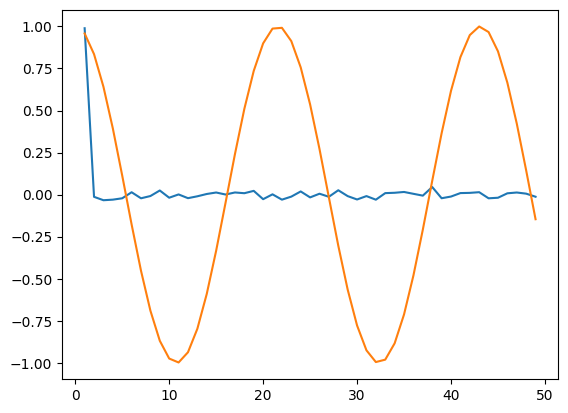

In [87]:
x = [i+1 for i in range(len(similarity))]
y = [binding_sim_theoretical(i, e)  for i in x]
plt.plot(x, similarity, label="Simulation")
plt.plot(x, y, label="Theoretical")
plt.show()

In [90]:
print(fhrr.similarity(snn_result[0], py_result[0]))

0.9771105026954793


In [92]:
print(cmath.acos(0.9771105026954793))

(0.2143705006359862-0j)


In [104]:
mat = [[ 7,  4,  4,], [ 1,  9,  5], [ 1,  4, 10]]

In [106]:
predicted = []
y_test    = []

for i in range(3):
    for j in range(15):
        y_test.append(i)

for i in range(3):
    for j in range(3):
        for k in range(mat[i][j]):
            if (i == j):
                predicted.append(i)
            else:
                predicted.append(j)

print(predicted)
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [107]:
## Classification report
from sklearn import metrics

print(
    f"Classification report for HD classifier:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for HD classifier:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.53      0.60      0.56        15
           2       0.53      0.67      0.59        15

    accuracy                           0.58        45
   macro avg       0.61      0.58      0.58        45
weighted avg       0.61      0.58      0.58        45


